In [175]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import re
import glob
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from datetime import datetime, timedelta
from collections import defaultdict
from multiprocessing import Manager

pd.set_option('display.max_columns', None)

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "9g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .appName('exploration') \
    .getOrCreate()

In [2]:
transactions1 = spark.read.parquet("../data/transactions/transactions_20210228_20210827_snapshot")
transactions2 = spark.read.parquet("../data/transactions/transactions_20210828_20220227_snapshot")
transactions3 = spark.read.parquet("../data/transactions/transactions_20220228_20220828_snapshot")

transactions = transactions1.union(transactions2).union(transactions3)

transactions = transactions.withColumn('user_id', F.col('user_id').cast(StringType()))
transactions = transactions.withColumn('merchant_abn', F.col('merchant_abn').cast(StringType()))

transactions.show(truncate=False)

+-------+------------+------------------+------------------------------------+--------------+
|user_id|merchant_abn|dollar_value      |order_id                            |order_datetime|
+-------+------------+------------------+------------------------------------+--------------+
|18478  |62191208634 |63.255848959735246|949a63c8-29f7-4ab0-ada4-99ac50a88952|2021-08-20    |
|2      |15549624934 |130.3505283105634 |6a84c3cf-612a-4574-835b-144a47353eff|2021-08-20    |
|18479  |64403598239 |120.15860593212783|b10dcc33-e53f-4254-863c-de5266810cbc|2021-08-20    |
|3      |60956456424 |136.6785200286976 |0f09c5a5-784e-4477-b049-8ee4dd069b7b|2021-08-20    |
|18479  |94493496784 |72.96316578355305 |f6c78c1a-4600-4c5f-8e97-6e9eb534b586|2021-08-20    |
|3      |76819856970 |448.529684285612  |5ace6a24-cdf0-4aa3-b571-1d9406b352b5|2021-08-20    |
|18479  |67609108741 |86.4040605836911  |d0e180f0-cb06-42a3-bd1a-c47dca15bc55|2021-08-20    |
|3      |34096466752 |301.5793450525113 |6fb1ff48-24bb-4f97-

In [3]:
consumer_fraud = spark.read.option("header", True).csv("../data/tables/consumer_fraud_probability.csv")
consumer_fraud = consumer_fraud.withColumn('order_datetime', F.col('order_datetime').cast(DateType()))
consumer_fraud = consumer_fraud.withColumn('fraud_probability', F.col('fraud_probability').cast('double'))

consumer_details = spark.read.parquet("../data/tables/consumer_user_details.parquet")
consumer_details = consumer_details.withColumn('user_id', F.col('user_id').cast('string'))
consumer_details = consumer_details.withColumn('consumer_id', F.col('consumer_id').cast('string'))

merchant_fraud = spark.read.option("header", True).csv("../data/tables/merchant_fraud_probability.csv")
merchant_fraud = merchant_fraud.withColumnRenamed('fraud_probability', 'merchant_fraud_probability')
merchant_fraud = merchant_fraud.withColumn('merchant_fraud_probability', F.col('merchant_fraud_probability').cast('double'))

tbl_consumer = spark.read.option("header", True).option("delimiter", "|").csv("../data/tables/tbl_consumer.csv")

tbl_consumer = tbl_consumer.filter(F.col("state").isin(["NSW", "WA", "NT", "VIC", "TAS", "QLD", "SA",   "ACT"]))
tbl_consumer = tbl_consumer.filter(F.col("gender").isin(["Female", "Male", "Undisclosed"]))
tbl_consumer = tbl_consumer.withColumn("postcode", tbl_consumer["postcode"].cast(IntegerType()))
tbl_consumer = tbl_consumer.withColumnRenamed("name", "consumer_name")

In [449]:
tbl_merchants = spark.read.parquet("../data/tables/tbl_merchants.parquet")
tbl_merchants = tbl_merchants.withColumn('tags', F.regexp_replace('tags', r'\(', r'\[')) \
    .withColumn('tags', F.lower(F.regexp_replace('tags', r'\)', r'\]')))

tbl_merchants = tbl_merchants.withColumn('tags1', (F.regexp_extract('tags', r'\[\[([^\]]*)\][^\[]*\[([^\]]*)\][^\[]*\[take rate: ([^\]]*)\]\]', idx=1)))
tbl_merchants = tbl_merchants.withColumn('tags2', (F.regexp_extract('tags', r'\[\[([^\]]*)\][^\[]*\[([^\]]*)\][^\[]*\[take rate: ([^\]]*)\]\]', idx=2)))
tbl_merchants = tbl_merchants.withColumn('tags3', (F.regexp_extract('tags', r'\[\[([^\]]*)\][^\[]*\[([^\]]*)\][^\[]*\[take rate: ([^\]]*)\]\]', idx=3)).cast(DoubleType()))

tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), "\\s+", " "))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ", except appliances", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), "rent al", "rental"))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ":", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " -", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " shops", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " services", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " service", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " and", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ", sales", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " ,", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ",,", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ",]", "]"))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), r"\[", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), r"\]", ""))

tbl_merchants = tbl_merchants.withColumnRenamed('tags3', 'take_rate')
tbl_merchants = tbl_merchants.withColumnRenamed('tags2', 'type')
tbl_merchants = tbl_merchants.withColumnRenamed("name", "merchant_name")
tbl_merchants = tbl_merchants.drop('tags')
tbl_merchants = tbl_merchants.withColumnRenamed('tags1', 'tags')

tbl_merchants.show(truncate=False)

+------------------------------------+------------+----------------------------------------------------------------+----+---------+
|merchant_name                       |merchant_abn|tags                                                            |type|take_rate|
+------------------------------------+------------+----------------------------------------------------------------+----+---------+
|Felis Limited                       |10023283211 |furniture, home furnishings, equipment, manufacturers           |e   |0.18     |
|Arcu Ac Orci Corporation            |10142254217 |cable, satellite, other pay television, radio                   |b   |4.22     |
|Nunc Sed Company                    |10165489824 |jewelry, watch, clock, silverware                               |b   |4.4      |
|Ultricies Dignissim Lacus Foundation|10187291046 |watch, clock, jewelry repair                                    |b   |3.29     |
|Enim Condimentum PC                 |10192359162 |music, musical instrument

In [5]:
full_transactions = transactions.join(consumer_details, on="user_id",how="left") \
                   .join(tbl_consumer, on="consumer_id",how="left") \
                   .join(consumer_fraud, on=["user_id", "order_datetime"],how="left") \
                   .join(tbl_merchants, on="merchant_abn",how="left") \
                   .join(merchant_fraud, on=["order_datetime", "merchant_abn"], how="left")

full_transactions.show(truncate=False)

+--------------+------------+-------+-----------+-------------------+------------------------------------+---------------+--------------------------+-----+--------+------+-----------------+---------------------------------+----------------------------------------------------------------+----+---------+--------------------------+
|order_datetime|merchant_abn|user_id|consumer_id|dollar_value       |order_id                            |consumer_name  |address                   |state|postcode|gender|fraud_probability|merchant_name                    |tags                                                            |type|take_rate|merchant_fraud_probability|
+--------------+------------+-------+-----------+-------------------+------------------------------------+---------------+--------------------------+-----+--------+------+-----------------+---------------------------------+----------------------------------------------------------------+----+---------+--------------------------+
|2022-0

In [6]:
print(full_transactions.where(F.col("merchant_name").isNull()).count(), full_transactions.count())
full_transactions = full_transactions.where(F.col("merchant_name").isNotNull())
print(full_transactions.where(F.col("merchant_name").isNull()).count(), full_transactions.count())

580863 14195717


0 13614854


In [7]:
postcodes = gpd.read_file("../data/landing/POA_2021_AUST_GDA2020_SHP")
postcodes = postcodes.to_crs(epsg='4326')

postcodes['lon'] = postcodes.geometry.centroid.x
postcodes['lat'] = postcodes.geometry.centroid.y
postcodes = postcodes.drop(columns='geometry')
postcodes = postcodes.loc[:, ['POA_CODE21', 'AREASQKM21', 'SHAPE_Leng', 'SHAPE_Area', 'lon', 'lat']]
postcodes = postcodes.rename(columns={'POA_CODE21': 'postcode'})

postcodes = spark.createDataFrame(postcodes)

full_transactions = full_transactions.join(postcodes, on='postcode')
full_transactions.show(truncate=False)

/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_85583/3306163271.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  postcodes['lon'] = postcodes.geometry.centroid.x
/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_85583/3306163271.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  postcodes['lat'] = postcodes.geometry.centroid.y


+--------+--------------+------------+-------+-----------+------------------+------------------------------------+-------------+---------------+-----+------+-----------------+-----------------------------------+----------------------------------------------------------------+----+---------+--------------------------+----------+-------------+--------------+------------------+-------------------+
|postcode|order_datetime|merchant_abn|user_id|consumer_id|dollar_value      |order_id                            |consumer_name|address        |state|gender|fraud_probability|merchant_name                      |tags                                                            |type|take_rate|merchant_fraud_probability|AREASQKM21|SHAPE_Leng   |SHAPE_Area    |lon               |lat                |
+--------+--------------+------------+-------+-----------+------------------+------------------------------------+-------------+---------------+-----+------+-----------------+-----------------------------

In [8]:
# Combine the census data into a single dataframe, by postcode
# https://www.abs.gov.au/census/find-census-data/datapacks?release=2021&product=GCP&geography=SA2&header=S
TABLES = [
    '2021Census_G02_AUST_POA.csv',
    '2021Census_G04A_AUST_POA.csv',
    '2021Census_G04B_AUST_POA.csv'
]
POSTCODE_COLUMN = 'POA_CODE_2021'
SELECTED_COLUMNS = [
    POSTCODE_COLUMN,
    'Median_age_persons', 
    'Median_tot_fam_inc_weekly', 
    'Median_tot_hhd_inc_weekly', 
    'Average_household_size', 
    'Tot_M', 
    'Tot_P', 
    'Tot_F'
]

census_df = None
for table in TABLES:
    df = spark.read.options(header=True) \
        .csv(f"../data/landing/2021_GCP_POA_for_AUS_short-header/2021 Census GCP Postal Areas for AUS/{table}")

    if census_df is None:
        census_df = df
    else:
        census_df = census_df.join(df, POSTCODE_COLUMN).drop(df[POSTCODE_COLUMN])

census_df = census_df.withColumn(POSTCODE_COLUMN, F.regexp_replace(F.col(POSTCODE_COLUMN), "(\D)", ""))
census_df = census_df.select(*SELECTED_COLUMNS)
for column in SELECTED_COLUMNS[1:]:
    census_df = census_df.withColumn(column, F.col(column).cast(DoubleType()))
census_df = census_df.withColumnRenamed("POA_CODE_2021", "postcode")
census_df.show(truncate=False)

full_transactions = full_transactions.join(census_df, on='postcode', how="left")
full_transactions.show(truncate=False)

# census_df.summary().show()
# census_df.write.mode('overwrite').parquet('../data/raw/census2021.parquet')

+--------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+
|postcode|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|Tot_M  |Tot_P  |Tot_F  |
+--------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+
|2000    |32.0              |2367.0                   |2225.0                   |2.1                   |14223.0|27936.0|13713.0|
|2007    |30.0              |2197.0                   |1805.0                   |2.1                   |3763.0 |7410.0 |3644.0 |
|2008    |28.0              |2453.0                   |1746.0                   |1.9                   |5315.0 |10400.0|5083.0 |
|2009    |37.0              |3035.0                   |2422.0                   |2.1                   |6391.0 |12658.0|6267.0 |
|2010    |36.0              |3709.0                   |2297.0                   |1.7             

24/10/02 00:41:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+--------------+------------+-------+-----------+------------------+------------------------------------+-------------+---------------+-----+------+-----------------+-----------------------------------+----------------------------------------------------------------+----+---------+--------------------------+----------+-------------+--------------+------------------+-------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+
|postcode|order_datetime|merchant_abn|user_id|consumer_id|dollar_value      |order_id                            |consumer_name|address        |state|gender|fraud_probability|merchant_name                      |tags                                                            |type|take_rate|merchant_fraud_probability|AREASQKM21|SHAPE_Leng   |SHAPE_Area    |lon               |lat                |Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size

In [186]:
retail_df = pd.read_excel("../data/landing/850103.xlsx", sheet_name="Data1", index_col=0)

states = ["NSW", "VIC", "QLD", "SA", "WA", "TAS", "NT", "ACT", "Total"]
trend_types = ["original", "seasonal", "trend"]
retail_columns = []
for trend_type in trend_types:
    for state in states:
        retail_columns.append(f"{state}_{trend_type}")

# Add date column
retail_df.columns = retail_columns
retail_df = retail_df.iloc[11:,:]
retail_df.index = pd.to_datetime(retail_df.index).strftime("%Y-%m")
retail_df['date'] = retail_df.index
retail_df.to_parquet("../data/raw/retail_sales.parquet", index=False)
retail_df

,NSW_original,VIC_original,QLD_original,SA_original,WA_original,TAS_original,NT_original,ACT_original,Total_original,NSW_seasonal,VIC_seasonal,QLD_seasonal,SA_seasonal,WA_seasonal,TAS_seasonal,NT_seasonal,ACT_seasonal,Total_seasonal,NSW_trend,VIC_trend,QLD_trend,SA_trend,WA_trend,TAS_trend,NT_trend,ACT_trend,Total_trend,date
1982-06,1234.2,887,494.1,277.2,301.5,77.5,NaN,55.3,3357.8,1309.8,952.9,518.6,288.9,321.2,81,NaN,58.3,3561.5,1305.1,946.3,515.7,291.8,317.8,81.9,NaN,57.7,3547,1982-06
1982-07,1265,921.3,515.6,296.1,316.4,82.7,NaN,56.3,3486.8,1291.9,955.9,518.1,296.2,320.4,83.7,NaN,56.8,3553.9,1302.4,954.3,517.3,296.3,319.1,82.2,NaN,58.2,3560.6,1982-07
1982-08,1217.6,883.2,501.4,288.4,300.5,78.1,NaN,55.4,3355.9,1314.4,950.7,521.4,303.6,318.5,83.3,NaN,58.9,3581.8,1298.1,963.6,518,301.1,320.4,82.4,NaN,58.9,3573.6,1982-08
1982-09,1244.9,917.9,517.7,293,312.3,79.1,NaN,57.5,3454.3,1292.4,971.9,521,303.7,319.6,82.5,NaN,59,3581.2,1293.1,974.1,517.9,306.2,321.6,82.4,NaN,60,3586.7,1982-09
1982-10,1264.2,983.3,504.2,307.9,318.7,78.7,NaN,61.9,3551.5,1289.4,987.7,510.9,310.8,322.2,81.1,NaN,61.6,3595.6,1293.2,985.5,518.1,311.3,322.6,82.5,NaN,61.2,3605.8,1982-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03,10873.5,9101.1,7185.7,2292.9,3975.6,721,313.8,673.1,35136.7,11082.4,9195.7,7362.9,2311.9,4034.1,718.2,331.3,673.8,35710.3,11151.2,9210.3,7363,2317.9,4032.8,720.4,329.7,673,35798.2,2024-03
2024-04,10639.8,8820.1,6907.1,2218.8,3800.2,682.8,311,641.2,34020.9,11183.2,9167,7361,2324.2,4045.3,718.3,330.9,673.4,35803.3,11164.9,9230.6,7379.6,2320.4,4059.1,720.3,331.3,675,35881.3,2024-04
2024-05,11090.6,9144.7,7206.6,2298.7,4004.9,707.1,335.3,667.6,35455.4,11179,9265.4,7403.9,2321.7,4096.2,722.4,332.2,677.6,35998.4,11179.7,9254.4,7401.6,2322.8,4087.5,720.2,333,676.9,35976,2024-05
2024-06,10777.4,8937.4,7163.6,2229,3973.2,678.1,346.4,661.2,34766.2,11217.2,9306.8,7439.5,2328.8,4129.9,722.5,334.8,682.6,36162.1,11195.8,9281.9,7426,2325.3,4116.3,720.1,334.7,678.8,36078.9,2024-06


In [185]:
retail_df = spark.read.parquet("../data/raw/retail_sales.parquet")
retail_df = retail_df.withColumn("month", F.month("date"))
retail_df = retail_df.withColumn("year", F.year("date"))
retail_df = retail_df.drop('date')
retail_df = retail_df.select([col for col in retail_df.columns if not col.endswith('trend')])
retail_df.show(truncate=False)

full_transactions = full_transactions.withColumn("month", F.month("order_datetime"))
full_transactions = full_transactions.withColumn("year", F.year("order_datetime"))
full_transactions = full_transactions.join(retail_df, on=['month', 'year'], how='left')
full_transactions.show(truncate=False)

+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+-----+----+
|NSW_original|VIC_original|QLD_original|SA_original|WA_original|TAS_original|NT_original|ACT_original|Total_original|NSW_seasonal|VIC_seasonal|QLD_seasonal|SA_seasonal|WA_seasonal|TAS_seasonal|NT_seasonal|ACT_seasonal|Total_seasonal|month|year|
+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+-----+----+
|1234.2      |887.0       |494.1       |277.2      |301.5      |77.5        |NULL       |55.3        |3357.8        |1309.8      |952.9       |518.6       |288.9      |321.2      |81.0        |NULL       |58.3        |3561.5        |6    |1982|
|1265.0      |921.3 

NameError: name 'full_transactions' is not defined

In [ ]:
full_transactions.write.mode("overwrite").parquet("../data/curated/transactions.parquet")

[29.55524469 69.74088753 28.34260128 28.61547889 28.69020429 28.35387345
 30.57903216 29.05714322 29.53973321 28.50447905 30.23903245 27.93103068
 59.77648897 28.34828039 66.52282263 30.57903216 28.50447905 28.34140136
 29.16784078 29.55524469 30.02429183 28.8067089  28.35274652 28.50447905
 33.01471361 28.79521209 30.57903216 28.3373702  28.39941282 31.34350232
 28.50447905 31.34350232 28.3373702  30.57903216 29.75107524 28.78568573
 30.57903216 28.45905354 28.69020429 56.43761255 29.53973321 29.53973321
 29.08815812 30.02429183 29.85552419 29.55524469 30.57903216 28.65161761
 28.2815079  30.57903216 29.10401486 28.53232082 29.55524469 30.57903216
 30.23841986 28.20537898 29.53947304 32.49943591 30.57903216 28.50447905
 28.69020429 29.27259775 28.24267057 30.02429183 30.02429183 29.0263052
 29.05393297 28.8367477  31.48391056 28.34721657 28.50447905 30.57903216
 30.09158408 29.52661883 28.35898078 63.37734365 30.57903216 28.61661768
 30.57903216 28.95733256 28.10085623 31.02465578 28.

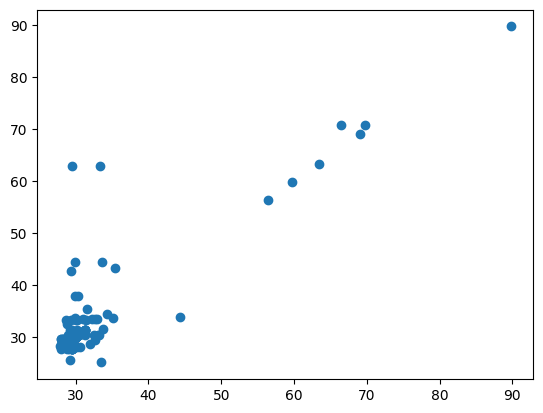

In [108]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

transactions = spark.read.parquet("../data/curated/transactions.parquet")

transactions = transactions.where(F.col("merchant_fraud_probability").isNotNull()).toPandas()

categories = transactions.select('tags').distinct().toPandas().dropna().astype("string")['tags'].to_list()

X = transactions.drop('merchant_fraud_probability', axis=1)
y = transactions['merchant_fraud_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

columns = list(X.columns.values)

preprocessor = ColumnTransformer(
    transformers=[
        ('tags', Pipeline([
            ('onehot', OneHotEncoder(categories=[categories], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('tags')]), # tags
        ('state', Pipeline([
            ('onehot', OneHotEncoder(categories=[['NSW', 'VIC', 'TAS', 'QLD', 'WA', 'SA', 'NT', 'ACT']], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('state')]), # state
        ('dollar_value', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('dollar_value')]), # dollar value
        ('take_rate', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('take_rate')]) # take rate
    ]
)

knn = KNeighborsRegressor(n_neighbors=3, weights='distance', p=1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn)
])

pipeline.fit(X_train, y_train)

# Display graph of predicted vs actual
plt.scatter(pipeline.predict(X_test), y_test)
print(f"RMSE: {root_mean_squared_error(y_test, pipeline.predict(X_test))}")

In [115]:
pipeline.fit(X, y)
transactions = pd.read_parquet("../data/curated/transactions.parquet")

mask = transactions['merchant_fraud_probability'].isna()

transactions_to_predict = transactions.loc[mask, :]
X_to_predict = transactions_to_predict.drop('merchant_fraud_probability', axis=1)

transactions.loc[mask, 'merchant_fraud_probability'] = pipeline.predict(X_to_predict)
transactions.to_parquet("../data/curated/transactions1.parquet")

24/10/02 17:25:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


RMSE: 7.446657155732339


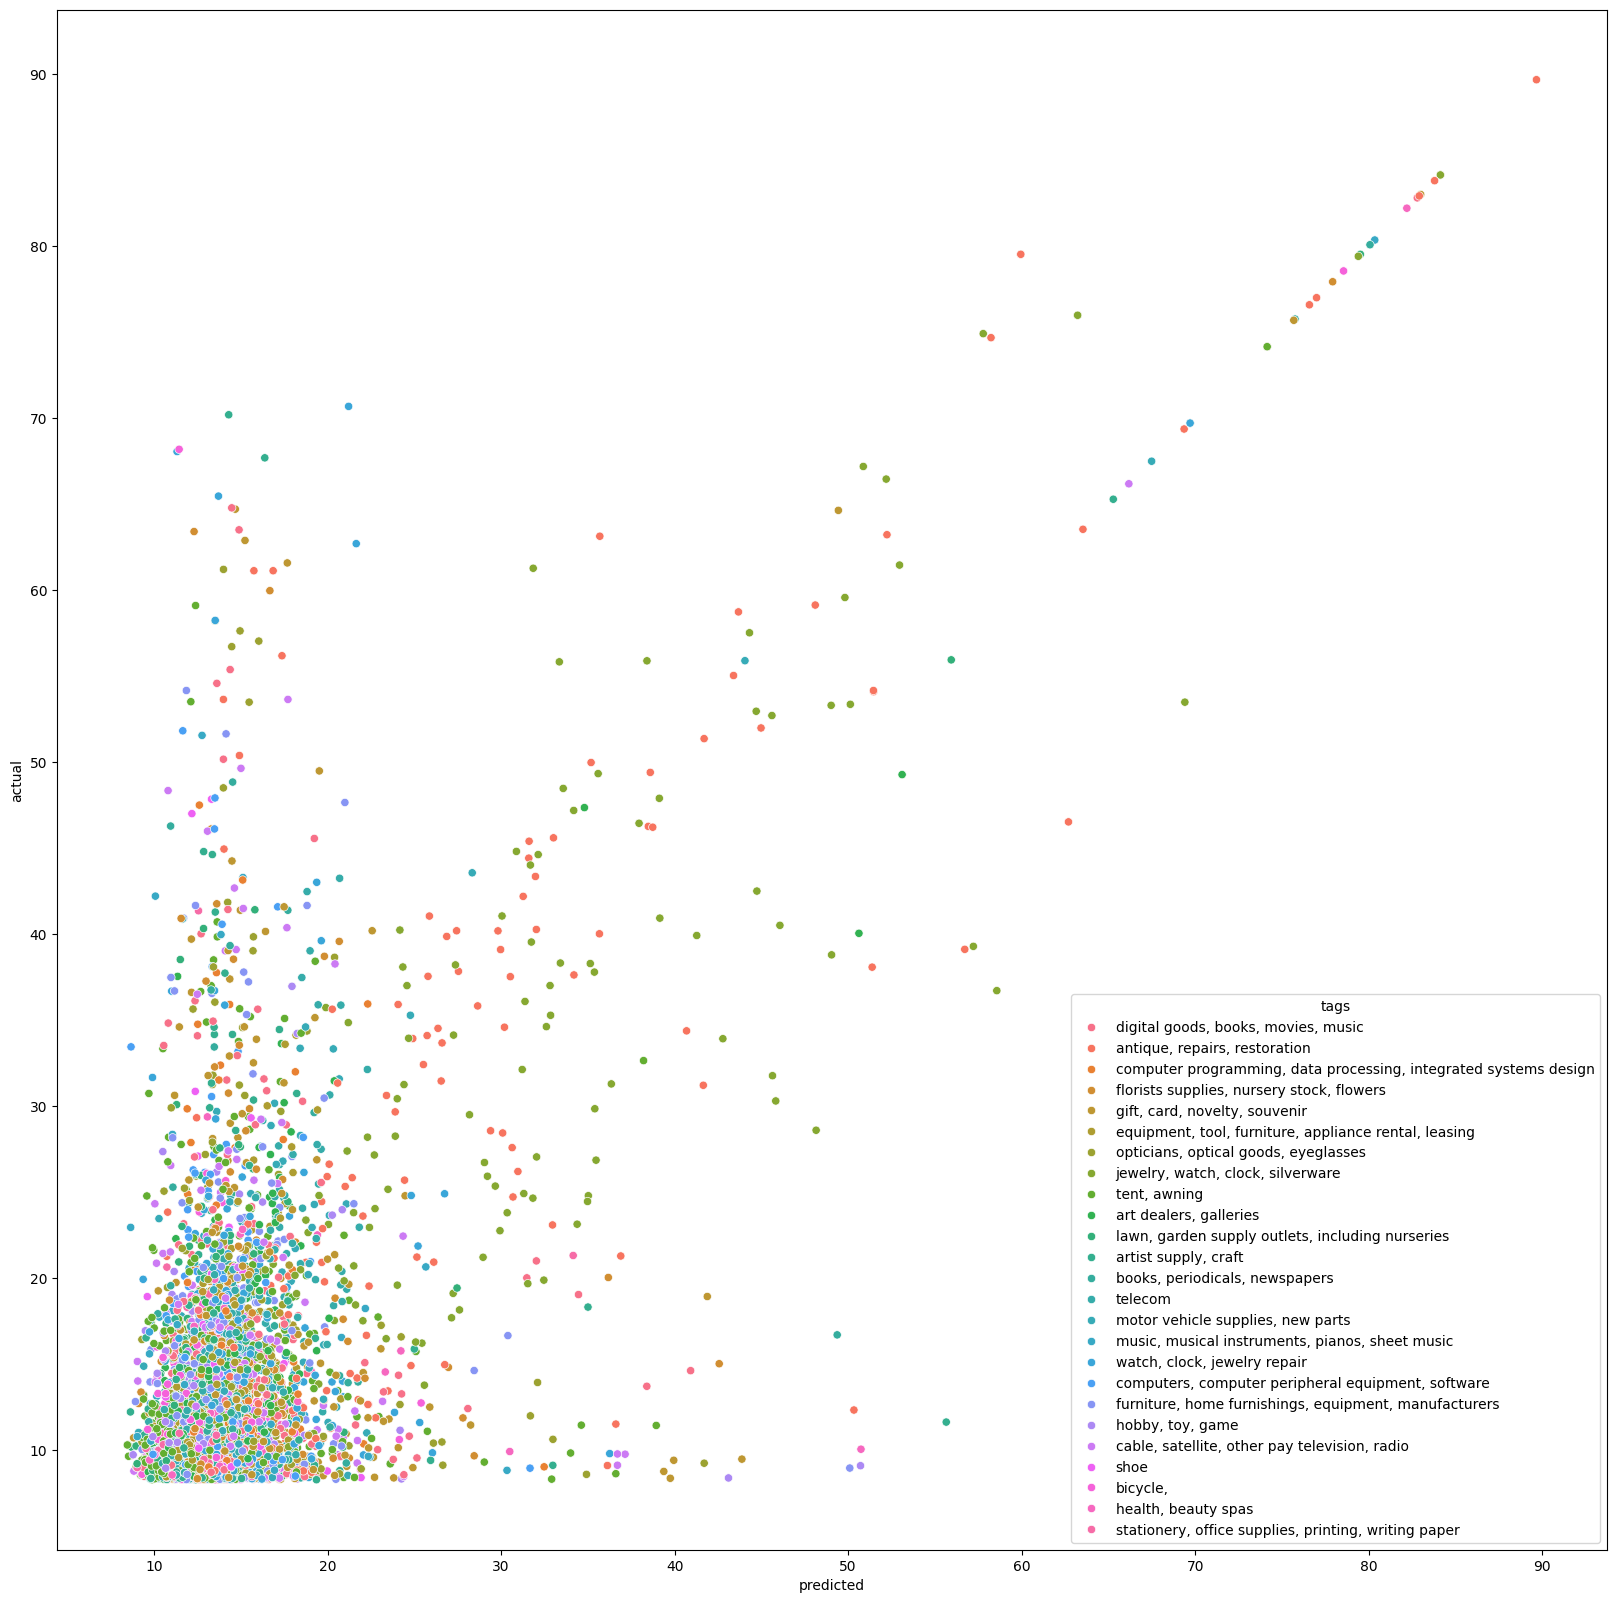

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

transactions = spark.read.parquet("../data/curated/transactions1.parquet")

categories = transactions.select('tags').distinct().toPandas().dropna().astype("string")['tags'].to_list()
transactions = transactions.where(F.col("fraud_probability").isNotNull()).toPandas()

X = transactions.drop('fraud_probability', axis=1)
y = transactions['fraud_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

columns = list(X.columns.values)

preprocessor = ColumnTransformer(
    transformers=[
        ('tags', Pipeline([
            ('onehot', OneHotEncoder(categories=[categories], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('tags')]), # tags
        ('state', Pipeline([
            ('onehot', OneHotEncoder(categories=[['NSW', 'VIC', 'TAS', 'QLD', 'WA', 'SA', 'NT', 'ACT']], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('state')]), # state
        ('dollar_value', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('dollar_value')]), # dollar value
        ('take_rate', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('take_rate')]) # take rate
    ]
)

knn = KNeighborsRegressor(n_neighbors=int(math.sqrt(len(transactions)) / 2), weights='distance', p=1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn)
])

X = transactions.drop('fraud_probability', axis=1)
y = transactions['fraud_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

pipeline.fit(X_train, y_train)

combined = X_test
combined['predicted'] = pipeline.predict(X_test)
combined['actual'] = y_test
plt.figure(figsize=(20, 20))
sns.scatterplot(combined, x='predicted', y='actual', hue='tags')

print(f"RMSE: {root_mean_squared_error(y_test, pipeline.predict(X_test))}")

In [172]:
# Add features to get transactions ready to pass to model
transactions = spark.read.parquet("../data/curated/transactions2.parquet")
transactions = transactions.withColumn('expected_revenue', 
                                       transactions.dollar_value
                                       * (1.0 - transactions.merchant_fraud_probability / 100.0) 
                                       * (1.0 - transactions.fraud_probability / 100.0) 
                                       * transactions.take_rate / 100.0)
transactions = transactions.withColumn('day_of_week', F.dayofweek('order_datetime'))
transactions = transactions.withColumn('day_of_month', F.dayofmonth('order_datetime'))
transactions = transactions.withColumn('day_of_year', F.dayofyear('order_datetime'))
transactions = transactions.withColumn('month', F.month('order_datetime'))

transactions = transactions.withColumn(
    "is_holiday",
    F.when(F.col("order_datetime").isin([
        '2021-11-26',
        '2021-11-27',
        '2021-11-28',
        '2021-11-29',
        '2021-12-24',
        '2021-12-25',
        '2021-12-26',
    ]), F.lit(1)).otherwise(F.lit(0))
)

transactions = transactions.withColumn(
    "seasonal_sales",
    F.when(F.col("state") == "NSW", F.col("NSW_seasonal"))
     .when(F.col("state") == "VIC", F.col("VIC_seasonal"))
     .when(F.col("state") == "QLD", F.col("QLD_seasonal"))
     .when(F.col("state") == "SA", F.col("SA_seasonal"))
     .when(F.col("state") == "WA", F.col("WA_seasonal"))
     .when(F.col("state") == "TAS", F.col("TAS_seasonal"))
     .when(F.col("state") == "NT", F.col("NT_seasonal"))
     .when(F.col("state") == "ACT", F.col("ACT_seasonal"))
     .otherwise(None)
)

transactions = transactions.withColumn(
    "original_sales",
    F.when(F.col("state") == "NSW", F.col("NSW_original"))
     .when(F.col("state") == "VIC", F.col("VIC_original"))
     .when(F.col("state") == "QLD", F.col("QLD_original"))
     .when(F.col("state") == "SA", F.col("SA_original"))
     .when(F.col("state") == "WA", F.col("WA_original"))
     .when(F.col("state") == "TAS", F.col("TAS_original"))
     .when(F.col("state") == "NT", F.col("NT_original"))
     .when(F.col("state") == "ACT", F.col("ACT_original"))
     .otherwise(None)
)

transactions = transactions.withColumnRenamed("Total_seasonal", "total_seasonal_sales")
transactions = transactions.withColumnRenamed("Total_original", "total_original_sales")
transactions = transactions.select([col for col in transactions.columns if not col.endswith('original')])
transactions = transactions.select([col for col in transactions.columns if not col.endswith('seasonal')])

transactions.write.mode('overwrite').parquet("../data/curated/transactions3.parquet")
transactions.where(F.col('order_datetime') == '2021-12-26').show(truncate=False)

+-----+----+--------+--------------+------------+-------+-----------+------------------+------------------------------------+------------------+-------------------------------+-----+------+------------------+--------------------------------------+-----------------------------------------------------+----+---------+--------------------------+----------+---------------+----------------+------------------+-------------------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+--------------------+--------------------+--------------------+-----------+------------+-----------+----------+--------------+--------------+
|month|year|postcode|order_datetime|merchant_abn|user_id|consumer_id|dollar_value      |order_id                            |consumer_name     |address                        |state|gender|fraud_probability |merchant_name                         |tags                                                 |type|take_rat

In [546]:
from pyspark.sql.window import Window
from pyspark.sql import DataFrame

transactions = spark.read.parquet("../data/curated/transactions3.parquet")

def skewness_udf(column):
    return (F.mean(column) - F.median(column)) / F.stddev(column)

window_spec = Window.partitionBy("merchant_abn").orderBy("order_datetime")

agg_df = transactions.groupBy("merchant_abn").agg(
    F.expr("percentile_approx(fraud_probability, 0.5)").alias("fraud_probability_median"),
    skewness_udf(F.col("fraud_probability")).alias("fraud_probability_skewness"),
    F.expr("percentile_approx(dollar_value, 0.5)").alias("dollar_value_median"),
    F.expr("percentile_approx(expected_revenue, 0.5)").alias("expected_revenue_median"),
    skewness_udf(F.col("dollar_value")).alias("dollar_value_skewness"),
    F.count("merchant_abn").alias("record_count"),
    F.first("tags").alias("tags"),
    F.first("take_rate").alias("take_rate"),
    F.mean("merchant_fraud_probability").alias("merchant_fraud_probability"),
    F.mean("dollar_value").alias("mean_dollar_value"),
)

agg_df.show()

+------------+------------------------+--------------------------+-------------------+-----------------------+---------------------+------------+--------------------+---------+--------------------------+------------------+
|merchant_abn|fraud_probability_median|fraud_probability_skewness|dollar_value_median|expected_revenue_median|dollar_value_skewness|record_count|                tags|take_rate|merchant_fraud_probability| mean_dollar_value|
+------------+------------------------+--------------------------+-------------------+-----------------------+---------------------+------------+--------------------+---------+--------------------------+------------------+
| 10441711491|      13.981469844702758|       0.38977680993708913|  4184.883294138098|     146.31870423556205|   0.4506005262127406|           3|motor vehicle sup...|     5.77|        29.555244690425024| 5751.207887182689|
| 10487253336|      13.091596850582814|        0.2043608445425334| 359.87222862385426|      7.37545284454379

In [547]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

y = 'mean_dollar_value'
df = agg_df.toPandas()
df = df.fillna(0)
df['record_count'] = np.log(df['record_count'])
# df['dollar_value_median'] = np.log(df['dollar_value_median'])
# df['expected_revenue_median'] = np.log(df['expected_revenue_median'])
df[y] = np.log(df[y])
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=0))
])

df['cluster'] = pipeline.fit_predict(df[[
    'record_count', 
    # 'merchant_fraud_probability', 
    y
]])

fig = px.scatter(
    df, 
    x='record_count', 
    y=y, 
    color='cluster', 
    title='log(mean dollar value) vs log(sales) by KMeans Cluster', 
    labels={
        'record_count': 'log(sales)',
        'expected_revenue_median': 'log(mean dollar value)'
    },
    hover_data=['merchant_abn']
)

fig.show()

In [548]:
fig = px.scatter(
    df, 
    x='record_count', 
    y=y, 
    color='tags', 
    title='log(mean dollar value) vs log(sales) by KMeans Cluster', 
    labels={
        'record_count': 'log(sales)',
        y: 'log(mean dollar value)'
    },
    hover_data=['merchant_abn']
)

# Display plot
fig.show()

# Presentation
1. Problem overview - how to choose best merchants, which segments of merchants to take from
2. Preprocessing data steps - removal of outliers
3. Interesting merchants - weird distributions
4. Fraud imputing values, took average fraud
5. Creating model to rank
6. Segmentation - by log(expected revenue) vs log(sales)
7. Further actions - limitations, assumptions

In [ ]:
# Get distributions for tags after clusters
# Create xgboost models



Validation MSE: 158078.77008078128
Validation RMSE: 299.63297328109155


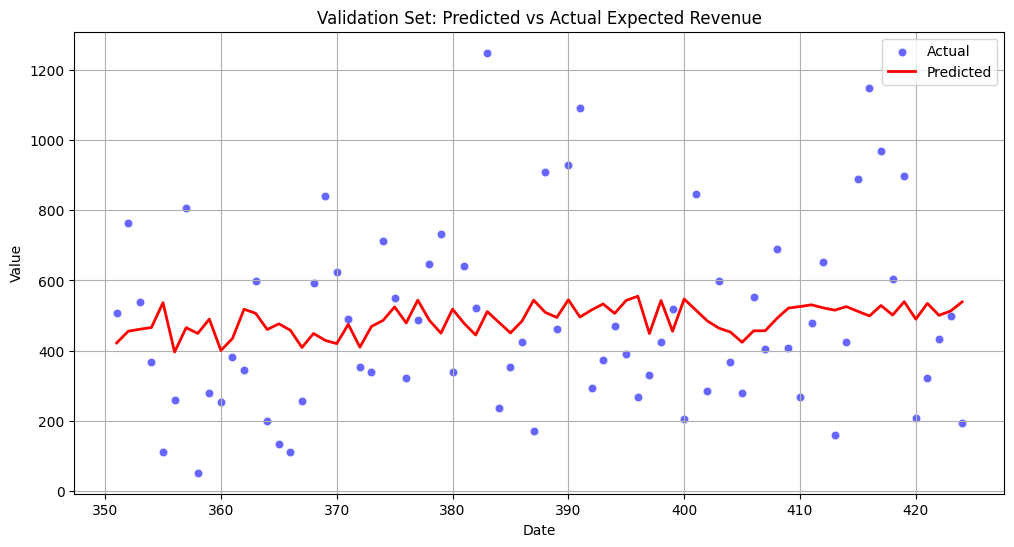

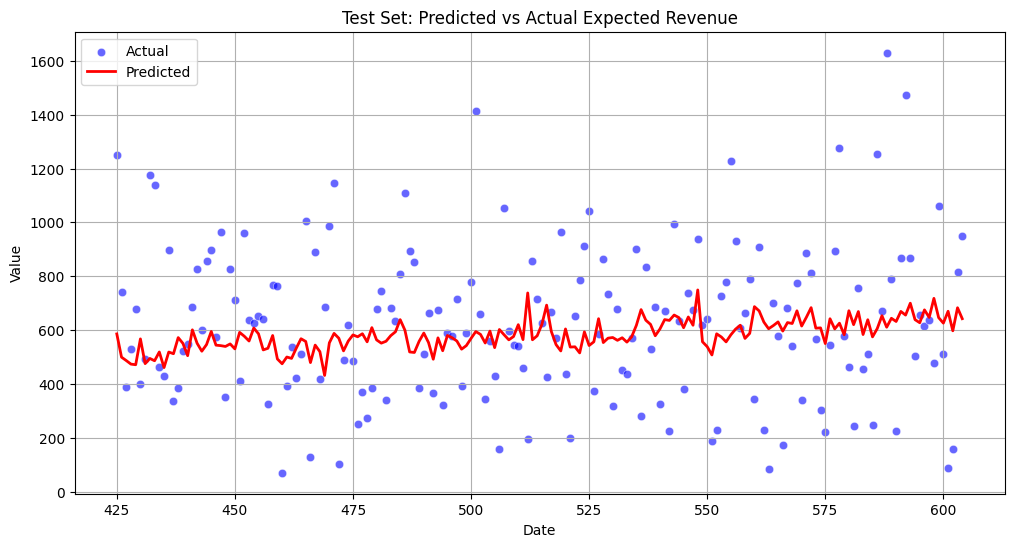

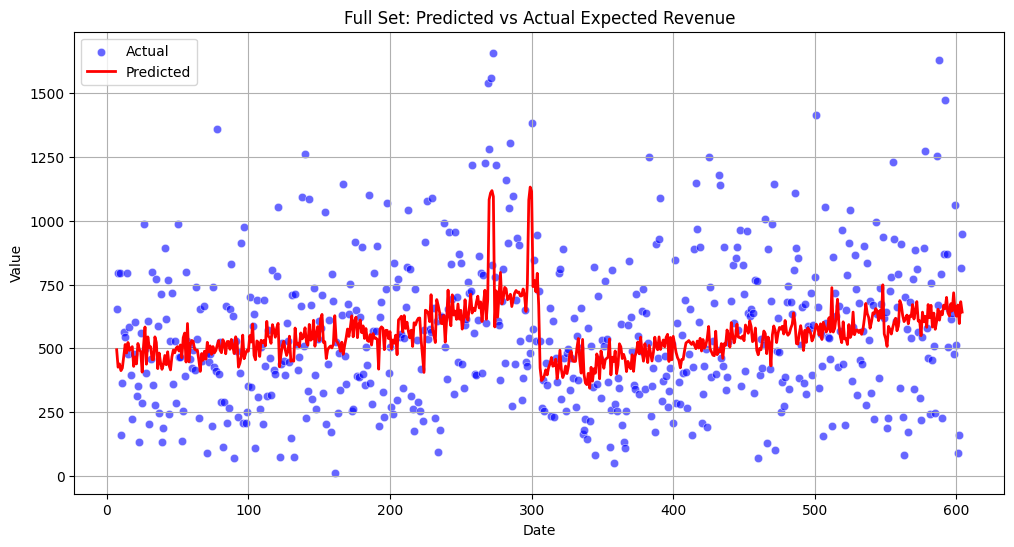

,day_of_month,day_of_year,expected_revenue,is_holiday,mean_dollar_value,mean_fraud_probability,mean_household_size,mean_merchant_fraud_probability,median_age,median_family_income,median_household_income,month,moving_average_expected_revenue,moving_average_mean_dollar_value,moving_average_num_sales,num_sales,order_datetime,postcode_population,total_original_sales,total_seasonal_sales
7,7,66,653.843036,0,1936.687497,10.467362,2.687500,29.866340,40.500000,1992.875000,1621.750000,3,550.948310,3026.290504,4.714286,8.000000,2021-03-07,14194.500000,30336.0,30610.5
8,8,67,794.609042,0,3143.615834,11.732680,2.433333,29.712954,46.666667,1740.000000,1728.250000,3,602.829844,2795.837049,5.571429,6.000000,2021-03-08,4443.500000,30336.0,30610.5
9,9,68,794.008871,0,2296.578714,12.772059,2.387500,29.403690,40.500000,2048.875000,1467.666667,3,600.390601,2898.879964,5.285714,8.000000,2021-03-09,6851.625000,30336.0,30610.5
10,10,69,161.878834,0,3936.744123,10.754740,2.100000,29.349527,59.000000,1125.000000,1750.250000,3,616.954771,2847.941318,5.571429,1.000000,2021-03-10,373.000000,30336.0,30610.5
11,11,70,365.121990,0,1721.646481,13.966205,2.140000,29.919139,49.200000,1949.400000,777.000000,3,577.820328,3169.410936,4.857143,5.000000,2021-03-11,3789.400000,30336.0,30610.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,20,20,473.525513,0,2142.025879,11.722537,2.446385,29.655840,43.577969,1967.667328,1595.923827,1,461.428205,2142.523891,5.279310,5.417175,2023-01-20 00:00:00,9535.614928,34338.4,35362.8
0,21,21,476.540283,0,2141.763184,11.722537,2.446385,29.655840,43.577969,1967.667328,1595.923827,1,464.457969,2142.537144,5.313532,5.451839,2023-01-21 00:00:00,9535.614928,34338.4,35362.8
0,22,22,479.553467,0,2141.485596,11.722537,2.446385,29.655840,43.577969,1967.667328,1595.923827,1,467.482683,2142.417027,5.347993,5.486519,2023-01-22 00:00:00,9535.614928,34338.4,35362.8
0,23,23,482.565643,0,2141.198730,11.722537,2.446385,29.655840,43.577969,1967.667328,1595.923827,1,470.503370,2142.214914,5.382590,5.521207,2023-01-23 00:00:00,9535.614928,34338.4,35362.8


In [339]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error

retail_df = spark.read.parquet("../data/raw/retail_sales.parquet")
retail_df = retail_df.withColumn("month", F.month("date"))
retail_df = retail_df.withColumn("year", F.year("date"))
retail_df = retail_df.drop('date')
retail_df = retail_df.select([col for col in retail_df.columns if not col.endswith('trend')])
# retail_df.show(truncate=False)
result = retail_df.collect()

retail_sales = {(row['year'], row['month']): (row['Total_original'], row['Total_seasonal']) for row in result}


transactions = spark.read.parquet("../data/curated/transactions3.parquet")
transactions = transactions.groupBy("merchant_abn", "order_datetime").agg(
    F.sum("expected_revenue").alias("expected_revenue"),
    F.mean("fraud_probability").alias("mean_fraud_probability"),
    F.mean("dollar_value").alias("mean_dollar_value"),
    F.count("merchant_abn").alias("num_sales"),
    F.first("tags").alias("tags"),
    F.first("take_rate").alias("take_rate"),
    F.mean("merchant_fraud_probability").alias("mean_merchant_fraud_probability"),
    F.mean("Median_age_persons").alias("median_age"),
    F.mean("Median_tot_fam_inc_weekly").alias("median_family_income"),
    F.mean("Median_tot_hhd_inc_weekly").alias("median_household_income"),
    F.mean("Average_household_size").alias("mean_household_size"),
    F.mean("Tot_P").alias("postcode_population"),
    F.first("day_of_week").alias("day_of_week"),
    F.first("day_of_month").alias("day_of_month"),
    F.first("day_of_year").alias("day_of_year"),
    F.first("month").alias("month"),
    F.first("year").alias("year"),
    F.mean("seasonal_sales").alias("seasonal_sales"),
    F.mean("original_sales").alias("original_sales"),
    F.first("total_seasonal_sales").alias("total_seasonal_sales"),
    F.first("total_original_sales").alias("total_original_sales"),
    F.first("is_holiday").alias("is_holiday"),
)


transactions = transactions.sort(F.col("order_datetime"), F.col("merchant_abn"))

# TODO: do this for other merchants
df = transactions.where(F.col("merchant_abn") == '79827781481')

df = df.toPandas()

def create_lagged_features(df, n_lags, column):
    df[f'moving_average_{column}'] = 0
    for lag in range(1, n_lags + 1):
        df[f'lag_{column}_{lag}'] = df[column].shift(lag)
        df[f'moving_average_{column}'] += df[f'lag_{column}_{lag}']
    df[f'moving_average_{column}'] /= n_lags
    return df

def lag_feature(df, n_lags, column):
    df[column] = df[column].shift(n_lags)
    return df

def create_test_train_validate_split(X, y, train_size=0.7, val_size=0.15):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=(1 - train_size), shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=(val_size / (train_size + val_size)), shuffle=False)

    return X_train, y_train, X_val, y_val, X_test, y_test

def predict_single_step(model, df, prediction_columns, imputing_columns, n_lags):
    last_row = df.tail(1)

    # Add date columns
    next_row = pd.DataFrame()
    next_row['order_datetime'] = [pd.to_datetime(last_row['order_datetime'].values[-1] + pd.Timedelta(days=1))]
    next_row['day_of_year'] = next_row['order_datetime'].dt.dayofyear
    next_row['day_of_month'] = next_row['order_datetime'].dt.day
    next_row['month'] = next_row['order_datetime'].dt.month
    next_row['is_holiday'] = next_row['order_datetime'].isin(pd.to_datetime([
        '2021-11-26',
        '2021-11-27',
        '2021-11-28',
        '2021-11-29',
        '2021-12-24',
        '2021-12-25',
        '2021-12-26',

        '2022-11-25',
        '2022-11-26',
        '2022-11-27',
        '2022-11-28',
        '2022-12-24',
        '2022-12-25',
        '2022-12-26',
    ]))

    # Add sales columns
    year = next_row['order_datetime'].dt.year.values[-1]
    month = next_row['order_datetime'].dt.month.values[-1]
    next_row['total_original_sales'], next_row['total_seasonal_sales'] = retail_sales[(year, month)]

    # Add moving average (prediction) columns
    for col in prediction_columns:
        next_row[f'moving_average_{col}'] = df.tail(n_lags)[col].mean()

    # Add columns imputed by mean
    for col in imputing_columns:
        next_row[col] = df[col].mean()

    next_row = next_row.sort_index(axis=1)
    y_pred = model.predict(next_row.drop(prediction_columns + ['order_datetime'], axis=1, errors='ignore'))

    # # TODO: Remove these?
    # df = lag_feature(df, 1, 'median_household_income')
    # df = lag_feature(df, 1, 'mean_merchant_fraud_probability')
    # df = lag_feature(df, 1, 'mean_fraud_probability')

    for i, col in enumerate(prediction_columns):
        next_row[col] = y_pred[0][i]
    
    next_row = next_row.sort_index(axis=1)
    return pd.concat([df, next_row])

def get_retail_sales(years, months):
    original_sales = []
    seasonal_sales = []
    for i in range(len(years)):
        original, seasonal = retail_sales[(years[i], months[i])]
        original_sales.append(original)
        seasonal_sales.append(seasonal)
    return original_sales, seasonal_sales

n_lags = 7

# Only use moving averages of these features to avoid overfitting to the current day/day before
df = create_lagged_features(df, n_lags, 'expected_revenue')
df = create_lagged_features(df, n_lags, 'num_sales')
df = create_lagged_features(df, n_lags, 'mean_dollar_value')
df = lag_feature(df, 1, 'median_household_income')
df = lag_feature(df, 1, 'mean_merchant_fraud_probability')
df = lag_feature(df, 1, 'mean_fraud_probability')

df = df.dropna()

DATA_COLUMNS = [
    'expected_revenue', 
    'num_sales',
    'mean_dollar_value',

    'order_datetime',
    'day_of_year', 
    'day_of_month', 
    'is_holiday', 
    'month', 

    'total_original_sales', 
    'total_seasonal_sales', 
    # 'seasonal_sales',
    # 'original_sales',
    'postcode_population',
    'median_age',
    'median_household_income',
    'median_family_income',
    'mean_household_size',
    'mean_fraud_probability',
    'mean_merchant_fraud_probability',
    
    'moving_average_expected_revenue',
    'moving_average_num_sales',
    'moving_average_mean_dollar_value',
] 

PREDICTION_COLUMNS = [
    'expected_revenue',
    'num_sales',
    'mean_dollar_value',
]

df = df[DATA_COLUMNS]
df = df.sort_index(axis=1)

X = df.drop(PREDICTION_COLUMNS + ['order_datetime'], axis=1)
y = df[PREDICTION_COLUMNS]

train_size = 0.7
val_size = 0.15

# TODO: Change up this split and also get future values
X_train, y_train, X_val, y_val, X_test, y_test = create_test_train_validate_split(X, y)

model = MultiOutputRegressor(XGBRegressor(n_estimators=1000, booster='gblinear'))
model.fit(X_train, y_train)

val_mse = mean_squared_error(y_val, model.predict(X_val))
print(f'Validation MSE: {val_mse}')

val_rmse = root_mean_squared_error(y_val, model.predict(X_val))
print(f'Validation RMSE: {val_rmse}')

def plot_predictions(actual, predicted, title='Predicted vs Actual'):
    plt.figure(figsize=(12, 6))
    
    sns.scatterplot(x=actual.index, y=actual, label='Actual', color='blue', alpha=0.6)
    sns.lineplot(x=actual.index, y=predicted, label='Predicted', color='red', linestyle='-', linewidth=2)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()

plot_predictions(y_val['expected_revenue'], model.predict(X_val)[:,0], title='Validation Set: Predicted vs Actual Expected Revenue')
plot_predictions(y_test['expected_revenue'], model.predict(X_test)[:,0], title='Test Set: Predicted vs Actual Expected Revenue')
plot_predictions(y['expected_revenue'], model.predict(X)[:,0], title='Full Set: Predicted vs Actual Expected Revenue')

# plot_predictions(y_val['num_sales'], model.predict(X_val)[:,1], title='Validation Set: Predicted vs Actual Number of Sales')
# plot_predictions(y_test['num_sales'], model.predict(X_test)[:,1], title='Test Set: Predicted vs Actual Number of Sales')
# plot_predictions(y['num_sales'], model.predict(X)[:,1], title='Full Set: Predicted vs Actual Number of Sales')

# plot_predictions(y_val['mean_dollar_value'], model.predict(X_val)[:,2], title='Validation Set: Predicted vs Actual Mean Dollar Value')
# plot_predictions(y_test['mean_dollar_value'], model.predict(X_test)[:,2], title='Test Set: Predicted vs Actual Mean Dollar Value')
# plot_predictions(y['mean_dollar_value'], model.predict(X)[:,2], title='Full Set: Predicted vs Actual Mean Dollar Value')

for i in range(90):
    df = predict_single_step(model, df, PREDICTION_COLUMNS, [
        # 'total_original_sales', 
        # 'total_seasonal_sales', 
        # 'seasonal_sales',
        # 'original_sales',
        'postcode_population',
        'median_age',
        'median_household_income',
        'median_family_income',
        'mean_household_size',
        'mean_fraud_probability',
        'mean_merchant_fraud_probability',
    ], 7)

df

In [342]:
columns = [
    'expected_revenue', 'mean_dollar_value', 'num_sales',
    'moving_average_expected_revenue', 'moving_average_mean_dollar_value', 'moving_average_num_sales'
]

# Create an empty dictionary to store the results
result_dict = {}

# Set a limit to the last 90 values from the final row
last_row_index = len(df) - 1

for col in columns:
    shifted_data = np.array([df[col].shift(i).iloc[len(df) - 1] for i in range(90)])  # Collect last 90 shifts

    # Add to the dictionary with shift index and column name
    for shift_idx, value in enumerate(shifted_data):
        if not np.isnan(value):  # Only add non-null values
            result_dict[f"{col}|{shift_idx}"] = value  # Use column and shift index

# Example to view part of the result
print(result_dict)

{'expected_revenue|0': 485.57745361328125, 'expected_revenue|1': 482.5656433105469, 'expected_revenue|2': 479.553466796875, 'expected_revenue|3': 476.540283203125, 'expected_revenue|4': 473.5255126953125, 'expected_revenue|5': 470.50860595703125, 'expected_revenue|6': 467.4891357421875, 'expected_revenue|7': 464.4665832519531, 'expected_revenue|8': 461.44000244140625, 'expected_revenue|9': 458.4086608886719, 'expected_revenue|10': 455.3672790527344, 'expected_revenue|11': 452.3171691894531, 'expected_revenue|12': 449.259521484375, 'expected_revenue|13': 446.19561767578125, 'expected_revenue|14': 443.12652587890625, 'expected_revenue|15': 440.0516052246094, 'expected_revenue|16': 436.9733581542969, 'expected_revenue|17': 435.99273681640625, 'expected_revenue|18': 435.02423095703125, 'expected_revenue|19': 434.0670166015625, 'expected_revenue|20': 433.12054443359375, 'expected_revenue|21': 432.18414306640625, 'expected_revenue|22': 433.1225280761719, 'expected_revenue|23': 434.0732421875

In [ ]:
import traceback
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

merchants = [
    row.merchant_abn for row in transactions.select("merchant_abn", "expected_revenue") \
    .groupBy("merchant_abn").agg(
        F.sum("expected_revenue").alias("expected_revenue")
    ).sort(F.col("expected_revenue").desc()) \
    .collect()
]

models = []

train_size = 0.7
test_size = 0.15

end_date = '2022-10-26'
start_date = '2021-02-28'
date_range = pd.date_range(start=start_date, end=end_date)

dates_df = pd.DataFrame(date_range, columns=['order_datetime'])
dates_df['order_datetime'] = pd.to_datetime(dates_df['order_datetime'])

DATA_COLUMNS = [
    'expected_revenue', 
    'num_sales',
    'mean_dollar_value',

    'order_datetime',
    'day_of_year', 
    'day_of_month', 
    'is_holiday', 
    'month', 

    'total_original_sales', 
    'total_seasonal_sales', 
    # 'seasonal_sales',
    # 'original_sales',
    'postcode_population',
    'median_age',
    'median_household_income',
    'median_family_income',
    'mean_household_size',
    'mean_fraud_probability',
    'mean_merchant_fraud_probability',
    
    'moving_average_expected_revenue',
    'moving_average_num_sales',
    'moving_average_mean_dollar_value',
] 

mean_row = spark.read.parquet('../data/curated/transactions3.parquet').agg(
    F.mean("Median_age_persons").alias("median_age"),
    F.mean("Median_tot_fam_inc_weekly").alias("median_family_income"),
    F.mean("Median_tot_hhd_inc_weekly").alias("median_household_income"),
    F.mean("Average_household_size").alias("mean_household_size"),
    F.mean("Tot_P").alias("postcode_population")
).collect()[0]

for i, merchant_abn in enumerate(merchants[:]):
    # i = i + 1401
    print(i, end=' ')
    # print(i)
    try:
        df = transactions.where(F.col("merchant_abn") == merchant_abn).sort('order_datetime').toPandas()
        df['order_datetime'] = pd.to_datetime(df['order_datetime'])
        df = dates_df.merge(df, on='order_datetime', how='left').fillna({
            'expected_revenue': 0,
            'num_sales': 0,
            'mean_dollar_value': 0,

            # 'median_age': mean_row['median_age'],
            # 'postcode_population': mean_row['postcode_population'],
            # 'median_household_income': mean_row['median_household_income'],
            # 'median_family_income': mean_row['median_family_income'],
            # 'mean_household_size': mean_row['mean_household_size'],

            'median_age': 0,
            'postcode_population': 0,
            'median_household_income': 0,
            'median_family_income': 0,
            'mean_household_size': 0,

            # 'total_original_sales': 0,
            # 'total_seasonal_sales': 0,

            'mean_merchant_fraud_probability': 0,
            'mean_fraud_probability': 0,
        })
        # print(df)

        df['day_of_year'] = df['order_datetime'].dt.dayofyear
        df['day_of_month'] = df['order_datetime'].dt.day
        df['month'] = df['order_datetime'].dt.month
        df['is_holiday'] = df['order_datetime'].isin(pd.to_datetime([
            '2021-11-26',
            '2021-11-27',
            '2021-11-28',
            '2021-11-29',
            '2021-12-24',
            '2021-12-25',
            '2021-12-26',

            '2022-11-25',
            '2022-11-26',
            '2022-11-27',
            '2022-11-28',
            '2022-12-24',
            '2022-12-25',
            '2022-12-26',
        ]))


        # Add sales columns
        years = df['order_datetime'].dt.year.values
        months = df['order_datetime'].dt.month.values
        df['total_original_sales'], df['total_seasonal_sales'] = get_retail_sales(years, months)

        # Only use moving averages of these features to avoid overfitting to the current day/day before
        df = create_lagged_features(df, n_lags, 'expected_revenue')
        df = create_lagged_features(df, n_lags, 'num_sales')
        df = create_lagged_features(df, n_lags, 'mean_dollar_value')
        df = lag_feature(df, 1, 'median_household_income')
        df = lag_feature(df, 1, 'mean_merchant_fraud_probability')
        df = lag_feature(df, 1, 'mean_fraud_probability')

        df = df.iloc[n_lags:]

        df = df[DATA_COLUMNS]
        df = df.sort_index(axis=1)

        X = df.drop(PREDICTION_COLUMNS + ['order_datetime'], axis=1)
        y = df[PREDICTION_COLUMNS]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

        grid_search = GridSearchCV(
            MultiOutputRegressor(XGBRegressor(n_estimators=1000, booster='gblinear')),
            param_grid={
                # 'estimator__alpha': [0, 0.1, 1.0, 10.0, 100.0],
                'estimator__alpha': [0],
            },
            scoring='neg_root_mean_squared_error',
            # cv=[(list(range(int(len(X_train) * 0.7 / 0.85))), list(range(int(len(X_train) * 0.7 / 0.85), len(X_train))))],
            cv=TimeSeriesSplit(n_splits=5),
            verbose=0,
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)

        best_rank = np.argwhere(grid_search.cv_results_['rank_test_score'] == 1)[0]

        models.append({
            'merchant_abn': merchant_abn, 
            'best_alpha': grid_search.best_params_['estimator__alpha'], 
            'val_rmse': -grid_search.best_score_,
            'test_rmse': root_mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test)),
            'std_val_score': grid_search.cv_results_['std_test_score'][best_rank][0],
            'fold0': -grid_search.cv_results_['split0_test_score'][best_rank][0],
            'fold1': -grid_search.cv_results_['split1_test_score'][best_rank][0],
            'fold2': -grid_search.cv_results_['split2_test_score'][best_rank][0],
            'fold3': -grid_search.cv_results_['split3_test_score'][best_rank][0],
            'fold4': -grid_search.cv_results_['split4_test_score'][best_rank][0],
        })
    except Exception as e:
        print(traceback.format_exc())

#     if i % 100 == 0:
#         results = pd.DataFrame(models)
#         results.to_csv(f"results_{i}.csv")

# results = pd.DataFrame(models)
# results.to_csv("results.csv")
# results
# grid_search.cv_results_

In [ ]:
import traceback
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

merchants = [
    row.merchant_abn for row in transactions.select("merchant_abn", "expected_revenue") \
    .groupBy("merchant_abn").agg(
        F.sum("expected_revenue").alias("expected_revenue")
    ).sort(F.col("expected_revenue").desc()) \
    .collect()
]

models = []

train_size = 0.7
test_size = 0.15

end_date = '2022-10-26'
start_date = '2021-02-28'
date_range = pd.date_range(start=start_date, end=end_date)

dates_df = pd.DataFrame(date_range, columns=['order_datetime'])
dates_df['order_datetime'] = pd.to_datetime(dates_df['order_datetime'])

DATA_COLUMNS = [
    'expected_revenue', 
    'num_sales',
    'mean_dollar_value',

    'order_datetime',
    'day_of_year', 
    'day_of_month', 
    'is_holiday', 
    'month', 

    'total_original_sales', 
    'total_seasonal_sales', 
    # 'seasonal_sales',
    # 'original_sales',
    'postcode_population',
    'median_age',
    'median_household_income',
    'median_family_income',
    'mean_household_size',
    'mean_fraud_probability',
    'mean_merchant_fraud_probability',
    
    'moving_average_expected_revenue',
    'moving_average_num_sales',
    'moving_average_mean_dollar_value',
] 

INFO_COLUMNS = [
    'mean_dollar_value',
    'num_sales',
    'expected_revenue',

    'moving_average_mean_dollar_value',
    'moving_average_num_sales',
    'moving_average_expected_revenue',
]

mean_row = spark.read.parquet('../data/curated/transactions3.parquet').agg(
    F.mean("Median_age_persons").alias("median_age"),
    F.mean("Median_tot_fam_inc_weekly").alias("median_family_income"),
    F.mean("Median_tot_hhd_inc_weekly").alias("median_household_income"),
    F.mean("Average_household_size").alias("mean_household_size"),
    F.mean("Tot_P").alias("postcode_population")
).collect()[0]

for i, merchant_abn in enumerate(merchants[:]):
    # i = i + 1401
    # print(i)
    try:
        df = transactions.where(F.col("merchant_abn") == merchant_abn).sort('order_datetime').toPandas()
        df['order_datetime'] = pd.to_datetime(df['order_datetime'])
        df = dates_df.merge(df, on='order_datetime', how='left').fillna({
            'expected_revenue': 0,
            'num_sales': 0,
            'mean_dollar_value': 0,

            # 'median_age': mean_row['median_age'],
            # 'postcode_population': mean_row['postcode_population'],
            # 'median_household_income': mean_row['median_household_income'],
            # 'median_family_income': mean_row['median_family_income'],
            # 'mean_household_size': mean_row['mean_household_size'],

            'median_age': 0,
            'postcode_population': 0,
            'median_household_income': 0,
            'median_family_income': 0,
            'mean_household_size': 0,

            # 'total_original_sales': 0,
            # 'total_seasonal_sales': 0,

            'mean_merchant_fraud_probability': 0,
            'mean_fraud_probability': 0,
        })
        # print(df)

        df['day_of_year'] = df['order_datetime'].dt.dayofyear
        df['day_of_month'] = df['order_datetime'].dt.day
        df['month'] = df['order_datetime'].dt.month
        df['is_holiday'] = df['order_datetime'].isin(pd.to_datetime([
            '2021-11-26',
            '2021-11-27',
            '2021-11-28',
            '2021-11-29',
            '2021-12-24',
            '2021-12-25',
            '2021-12-26',

            '2022-11-25',
            '2022-11-26',
            '2022-11-27',
            '2022-11-28',
            '2022-12-24',
            '2022-12-25',
            '2022-12-26',
        ]))


        # Add sales columns
        years = df['order_datetime'].dt.year.values
        months = df['order_datetime'].dt.month.values
        df['total_original_sales'], df['total_seasonal_sales'] = get_retail_sales(years, months)

        # Only use moving averages of these features to avoid overfitting to the current day/day before
        df = create_lagged_features(df, n_lags, 'expected_revenue')
        df = create_lagged_features(df, n_lags, 'num_sales')
        df = create_lagged_features(df, n_lags, 'mean_dollar_value')
        df = lag_feature(df, 1, 'median_household_income')
        df = lag_feature(df, 1, 'mean_merchant_fraud_probability')
        df = lag_feature(df, 1, 'mean_fraud_probability')

        df = df.iloc[n_lags:]

        df = df[DATA_COLUMNS]
        df = df.sort_index(axis=1)

        X = df.drop(PREDICTION_COLUMNS + ['order_datetime'], axis=1)
        y = df[PREDICTION_COLUMNS]

        model = MultiOutputRegressor(XGBRegressor(n_estimators=1000, booster='gblinear'))
        model.fit(X, y)

        # print(model.estimators_[0].coef_)
        # print(model.estimators_[0].feature_names_in_)

        model_data = {model.estimators_[0].feature_names_in_[i]: model.estimators_[0].coef_[i] for i in range(len(model.estimators_[0].feature_names_in_))}
        model_data['merchant_abn'] = merchant_abn

        for j in range(90):
            df = predict_single_step(model, df, PREDICTION_COLUMNS, [
                # 'total_original_sales', 
                # 'total_seasonal_sales', 
                # 'seasonal_sales',
                # 'original_sales',
                'postcode_population',
                'median_age',
                'median_household_income',
                'median_family_income',
                'mean_household_size',
                'mean_fraud_probability',
                'mean_merchant_fraud_probability',
            ], 7)

            for col in INFO_COLUMNS:
                model_data[f'{col}|{j}'] = df.iloc[-1][col]
        
        for col in INFO_COLUMNS:
            model_data[f'{col}_predicted_sum'] = df.iloc[-90:][col].sum()

        models.append(model_data)

    except Exception as e:
        print(traceback.format_exc())

    if i % 100 == 0:
        print(i, end=' ')
        results = pd.DataFrame(models)
        results.to_csv(f"predictions_{i}.csv")

results = pd.DataFrame(models)
results.to_csv("predictions.csv")
# results
# grid_search.cv_results_

     predicted
0   548.540405
1   551.173767
2   553.407349
3   554.644714
4   556.555786
..         ...
85  395.266174
86  394.962402
87  394.986084
88  395.291260
89  395.810028

[90 rows x 1 columns]


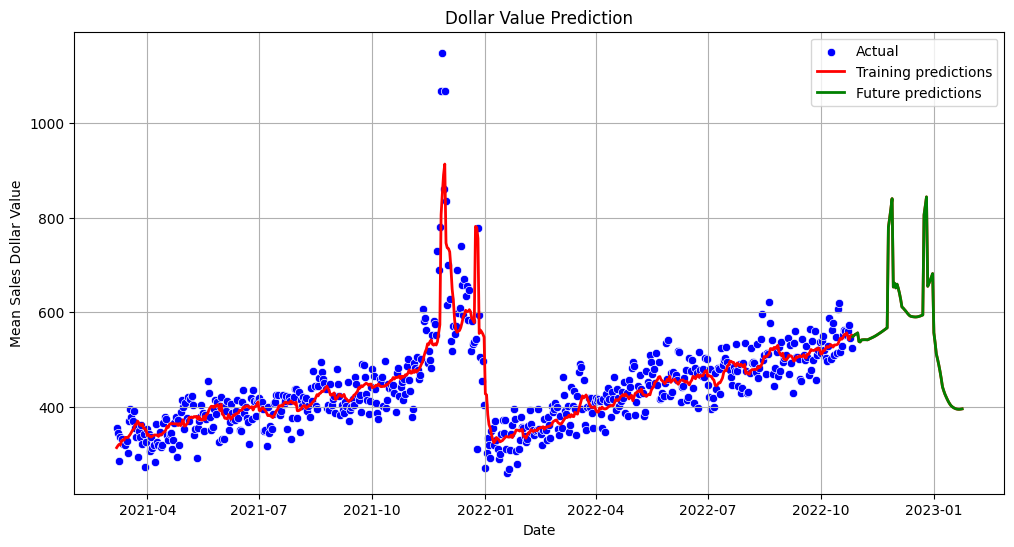

,day_of_month,day_of_year,expected_revenue,is_holiday,mean_dollar_value,mean_fraud_probability,mean_household_size,mean_merchant_fraud_probability,median_age,median_family_income,median_household_income,month,moving_average_expected_revenue,moving_average_mean_dollar_value,moving_average_num_sales,num_sales,order_datetime,postcode_population,total_original_sales,total_seasonal_sales,predicted
7,7.0,66.0,356.313678,0.0,41.940789,15.518113,2.384519,30.544199,44.711297,1867.271967,1625.207071,3.0,301.596550,41.276092,204.857143,239.0,2021-03-07,8048.158996,30336.0,30610.5,313.740112
8,8.0,67.0,344.533326,0.0,42.007132,15.223726,2.475983,30.485614,43.493450,1956.362445,1497.535565,3.0,301.159910,40.929826,206.571429,229.0,2021-03-08,9506.506550,30336.0,30610.5,317.833862
9,9.0,68.0,284.681022,0.0,42.472593,14.649878,2.456614,30.452162,43.613757,2004.248677,1608.764192,3.0,307.765097,40.953017,210.714286,189.0,2021-03-09,8839.264550,30336.0,30610.5,320.836243
10,10.0,69.0,336.076684,0.0,39.615404,15.644783,2.422689,30.564514,43.655462,1971.873950,1587.211640,3.0,310.125810,41.035590,212.142857,238.0,2021-03-10,10339.533613,30336.0,30610.5,319.420166
11,11.0,70.0,332.415008,0.0,40.235971,14.828256,2.485281,30.600327,43.683983,2020.000000,1584.642857,3.0,318.242181,40.902278,218.428571,231.0,2021-03-11,8595.774892,30336.0,30610.5,328.692566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-20,NaN,NaN,NaN,395.266174
86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-21,NaN,NaN,NaN,394.962402
87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-22,NaN,NaN,NaN,394.986084
88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-23,NaN,NaN,NaN,395.291260


In [557]:
merchant_abn = '89726005175'
graph_column = 'expected_revenue'

transactions = spark.read.parquet("../data/curated/transactions3.parquet")
transactions = transactions.groupBy("merchant_abn", "order_datetime").agg(
    F.sum("expected_revenue").alias("expected_revenue"),
    F.mean("fraud_probability").alias("mean_fraud_probability"),
    F.mean("dollar_value").alias("mean_dollar_value"),
    F.count("merchant_abn").alias("num_sales"),
    F.first("tags").alias("tags"),
    F.first("take_rate").alias("take_rate"),
    F.mean("merchant_fraud_probability").alias("mean_merchant_fraud_probability"),
    F.mean("Median_age_persons").alias("median_age"),
    F.mean("Median_tot_fam_inc_weekly").alias("median_family_income"),
    F.mean("Median_tot_hhd_inc_weekly").alias("median_household_income"),
    F.mean("Average_household_size").alias("mean_household_size"),
    F.mean("Tot_P").alias("postcode_population"),
    F.first("day_of_week").alias("day_of_week"),
    F.first("day_of_month").alias("day_of_month"),
    F.first("day_of_year").alias("day_of_year"),
    F.first("month").alias("month"),
    F.first("year").alias("year"),
    F.mean("seasonal_sales").alias("seasonal_sales"),
    F.mean("original_sales").alias("original_sales"),
    F.first("total_seasonal_sales").alias("total_seasonal_sales"),
    F.first("total_original_sales").alias("total_original_sales"),
    F.first("is_holiday").alias("is_holiday"),
)
transactions = transactions.sort(F.col("order_datetime"), F.col("merchant_abn"))
transactions = transactions.where(F.col("merchant_abn") == merchant_abn).toPandas()

training_results = spark.read.option("header", "true").csv("results_4000.csv")
training_results = training_results.drop(training_results.columns[0])

predictions = spark.read.option("header", "true").csv("predictions.csv")
predictions = predictions.drop(predictions.columns[0])

results = predictions.join(training_results, on='merchant_abn', how='inner')
results = results.select(*[F.col(column).cast(DoubleType()).alias(column) if column not in ['order_datetime', 'merchant_abn'] else F.col(column) for column in results.columns])
results = results.join(tbl_merchants, on='merchant_abn', how='left')

merchant_stats = spark.read.parquet("../data/curated/transactions3.parquet").groupBy('merchant_abn').agg(
    F.mean("merchant_fraud_probability").alias("merchant_mean_merchant_fraud_probability"),
    F.mean("fraud_probability").alias("merchant_mean_consumer_fraud_probability"),
    skewness_udf(F.col("dollar_value")).alias("dollar_value_skewness"),
    F.mean("dollar_value").alias("merchant_mean_dollar_value"),
    F.mean("expected_revenue").alias("merchant_mean_expected_revenue"),
)
results = results.join(merchant_stats, on='merchant_abn', how='left')


expected_revenue_columns = ','.join([f"`{graph_column}|{i}`" for i in range(90)])


merchant_results = results.where(F.col("merchant_abn") == merchant_abn).selectExpr(
    f"stack(90, {expected_revenue_columns}) as (predicted)"
).toPandas()
print(merchant_results)

merchant_results['order_datetime'] = pd.date_range(
    transactions['order_datetime'].values[-1] + pd.Timedelta(days=1), 
    transactions['order_datetime'].values[-1] + pd.Timedelta(days=90), 
)

# df = pd.concat([transactions, merchant_results])

df = transactions

df = create_lagged_features(df, n_lags, 'expected_revenue')
df = create_lagged_features(df, n_lags, 'num_sales')
df = create_lagged_features(df, n_lags, 'mean_dollar_value')
df = lag_feature(df, 1, 'median_household_income')
df = lag_feature(df, 1, 'mean_merchant_fraud_probability')
df = lag_feature(df, 1, 'mean_fraud_probability')

df = df.iloc[n_lags:]
df = df[DATA_COLUMNS]
df = df.sort_index(axis=1)

X = df.drop(PREDICTION_COLUMNS + ['order_datetime'], axis=1)
y = df[PREDICTION_COLUMNS]

model = MultiOutputRegressor(XGBRegressor(n_estimators=1000, booster='gblinear'))
model.fit(X, y)

df['predicted'] = model.predict(X)[:, PREDICTION_COLUMNS.index(graph_column)]
df = pd.concat([df, merchant_results])
df['order_datetime'] = pd.to_datetime(df['order_datetime'])
df = df.sort_values(by='order_datetime')
df['predicted'] = df['predicted'].astype(np.float64)

def plot_predictions(data, title='Revenue Prediction', y_label='Expected Revenue'):
    plt.figure(figsize=(12, 6))

    # sns.scatterplot(data.iloc[:-90], x='order_datetime', y='expected_revenue', label='Actual', color='#227c9d')
    # ax = sns.lineplot(data, x='order_datetime', y='predicted', label='Predicted', color='#f36d73', linewidth=2)

    sns.scatterplot(data.iloc[:-90], x='order_datetime', y=graph_column, label='Actual', color='blue')
    ax = sns.lineplot(data, x='order_datetime', y='predicted', label='Training predictions', color='red', linewidth=2)
    ax = sns.lineplot(data.tail(90), x='order_datetime', y='predicted', label='Future predictions', color='green', linewidth=2)

    # sns.scatterplot(x=index, y=actual, label='Actual', color='blue', alpha=0.6)
    # sns.lineplot(x=index, y=predicted, label='Predicted', color='red', linestyle='-', linewidth=2)

    # sns.scatterplot(data.iloc[:-90], x='order_datetime', y='expected_revenue', label='Actual', color='blue')
    # ax = sns.lineplot(data, x='order_datetime', y='predicted', label='Training predictions', color='red', linewidth=2)
    # ax = sns.lineplot(data.tail(90), x='order_datetime', y='predicted', label='Future predictions', color='green', linewidth=2)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()

plot_predictions(df, "Dollar Value Prediction", "Mean Sales Dollar Value")
df


/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_66498/4019600179.py:12: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



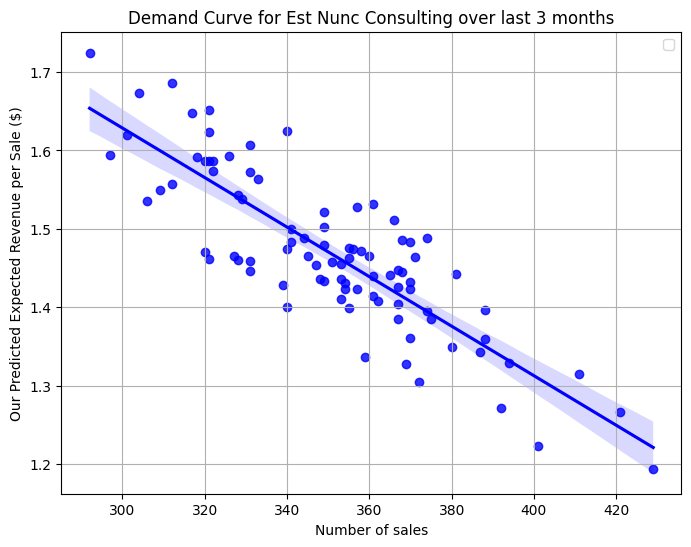

                            OLS Regression Results                            
Dep. Variable:              num_sales   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     225.5
Date:                Tue, 08 Oct 2024   Prob (F-statistic):           5.25e-26
Time:                        14:53:49   Log-Likelihood:                -367.64
No. Observations:                  90   AIC:                             739.3
Df Residuals:                      88   BIC:                             744.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [572]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.figure(figsize=(8, 6))
df['expected_revenue_per_sale'] = df['predicted'] / df['num_sales']
sns.regplot(df[-180:-90], x='num_sales', y='expected_revenue_per_sale', color='blue', fit_reg=True)

# plt.scatter(df[-180:]['num_sales'], df.iloc[-180:]['predicted'] / df.iloc[-180:]['num_sales'], color='blue')
plt.title("Demand Curve for Est Nunc Consulting over last 3 months")
plt.xlabel('Number of sales')
plt.ylabel('Our Predicted Expected Revenue per Sale ($)')
plt.legend()
plt.grid()
plt.show()

model = smf.ols('num_sales ~ expected_revenue_per_sale', data=df[-180:-90]).fit()
print(model.summary())

In [466]:
print(results.columns)

results.where(F.col("merchant_abn") == merchant_abn).select(
    "merchant_abn",
    "merchant_name",
    "merchant_mean_merchant_fraud_probability",
    "merchant_mean_consumer_fraud_probability",
    "dollar_value_skewness",
    "merchant_mean_dollar_value",
    "merchant_mean_expected_revenue",
    "tags",
    "type",
    "take_rate",
    'mean_merchant_fraud_probability',
    "day_of_month",
    "day_of_year",
    "is_holiday",
    "mean_fraud_probability",
    "mean_household_size",
    "mean_merchant_fraud_probability",
    "median_age",
    "median_family_income",
    "median_household_income",
    "month",
    "moving_average_expected_revenue",
    "moving_average_mean_dollar_value",
    "moving_average_num_sales",
    "postcode_population",
    "total_original_sales",
    "total_seasonal_sales",
).show()

['merchant_abn', 'day_of_month', 'day_of_year', 'is_holiday', 'mean_fraud_probability', 'mean_household_size', 'mean_merchant_fraud_probability', 'median_age', 'median_family_income', 'median_household_income', 'month', 'moving_average_expected_revenue', 'moving_average_mean_dollar_value', 'moving_average_num_sales', 'postcode_population', 'total_original_sales', 'total_seasonal_sales', 'mean_dollar_value|0', 'num_sales|0', 'expected_revenue|0', 'moving_average_mean_dollar_value|0', 'moving_average_num_sales|0', 'moving_average_expected_revenue|0', 'mean_dollar_value|1', 'num_sales|1', 'expected_revenue|1', 'moving_average_mean_dollar_value|1', 'moving_average_num_sales|1', 'moving_average_expected_revenue|1', 'mean_dollar_value|2', 'num_sales|2', 'expected_revenue|2', 'moving_average_mean_dollar_value|2', 'moving_average_num_sales|2', 'moving_average_expected_revenue|2', 'mean_dollar_value|3', 'num_sales|3', 'expected_revenue|3', 'moving_average_mean_dollar_value|3', 'moving_average_n

+------------+-------------------+----------------------------------------+----------------------------------------+---------------------+--------------------------+------------------------------+------------+----+---------+-------------------------------+------------+-----------+----------+----------------------+-------------------+-------------------------------+----------+--------------------+-----------------------+------+-------------------------------+--------------------------------+------------------------+-------------------+--------------------+--------------------+
|merchant_abn|      merchant_name|merchant_mean_merchant_fraud_probability|merchant_mean_consumer_fraud_probability|dollar_value_skewness|merchant_mean_dollar_value|merchant_mean_expected_revenue|        tags|type|take_rate|mean_merchant_fraud_probability|day_of_month|day_of_year|is_holiday|mean_fraud_probability|mean_household_size|mean_merchant_fraud_probability|median_age|median_family_income|median_household_i

In [501]:
ranked_merchants = results.select(
    "merchant_abn",
    "merchant_name",
    "merchant_mean_merchant_fraud_probability",
    "merchant_mean_consumer_fraud_probability",
    "dollar_value_skewness",
    "merchant_mean_dollar_value",
    "merchant_mean_expected_revenue",
    "tags",
    "type",
    "take_rate",
    "day_of_month",
    "day_of_year",
    "is_holiday",
    "mean_fraud_probability",
    "mean_household_size",
    "mean_merchant_fraud_probability",
    "median_age",
    "median_family_income",
    "median_household_income",
    "month",
    "moving_average_expected_revenue",
    "moving_average_mean_dollar_value",
    "moving_average_num_sales",
    "postcode_population",
    "total_original_sales",
    "total_seasonal_sales",
    "std_val_score",
    "test_rmse",
    "val_rmse",
    "num_sales_predicted_sum",
    "mean_dollar_value_predicted_sum",
    "expected_revenue_predicted_sum",
).sort(F.col("expected_revenue_predicted_sum").desc())

ranked_merchants.show(100, truncate=False)
ranked_merchants.write.mode("overwrite").csv("top_100.csv")


+------------+---------------------------------+----------------------------------------+----------------------------------------+----------------------+--------------------------+------------------------------+----------------------------------------------------------------+----+---------+------------+-----------+----------+----------------------+-------------------+-------------------------------+-----------+--------------------+-----------------------+---------+-------------------------------+--------------------------------+------------------------+-------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------------+-------------------------------+------------------------------+
|merchant_abn|merchant_name                    |merchant_mean_merchant_fraud_probability|merchant_mean_consumer_fraud_probability|dollar_value_skewness |merchant_mean_dollar_value|merchant_mean_expected_revenue|tags                   

24/10/08 03:15:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/08 03:15:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/08 03:15:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/08 03:15:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/08 03:15:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/08 03:15:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/08 0

<Figure size 800x600 with 0 Axes>

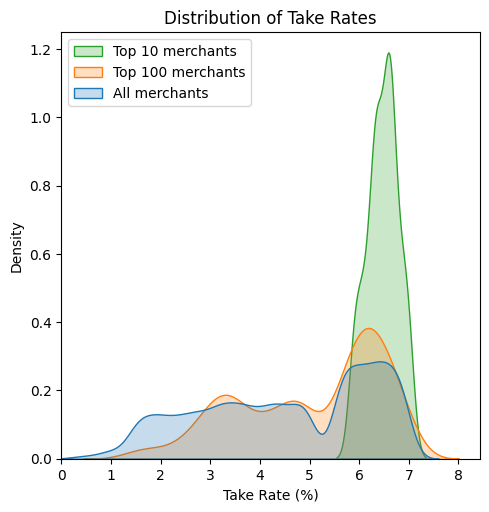

In [541]:
from pyspark.sql import Window

window_spec = Window.orderBy("expected_revenue_predicted_sum")
removed_fraud = ranked_merchants.where(F.col("merchant_mean_merchant_fraud_probability") < 50.0)

removed_fraud = removed_fraud.withColumn("row_num", F.row_number().over(window_spec)) \
    .withColumn("is_first_100", F.when(F.col("row_num") <= 100, 1).otherwise(0)) \
    .drop("row_num")

removed_fraud = removed_fraud.withColumn("row_num", F.row_number().over(window_spec)) \
    .withColumn("is_first_10", F.when(F.col("row_num") <= 10, 1).otherwise(0)) \
    .drop("row_num")

removed_fraud = removed_fraud.sort(F.col("expected_revenue_predicted_sum").desc()).toPandas()

all_merchants = removed_fraud.copy()
all_merchants['subset'] = 'All merchants'

top_100_merchants = removed_fraud.iloc[:100].copy()
top_100_merchants['subset'] = 'Top 100 merchants'

top_10_merchants = removed_fraud.iloc[:10].copy()
top_10_merchants['subset'] = 'Top 10 merchants'

merged_data = pd.concat([all_merchants, top_100_merchants, top_10_merchants])

plt.figure(figsize=(8, 6), frameon=False)
ax = sns.displot(data=merged_data, x='take_rate', hue="subset", bw_adjust=0.6, kind="kde", common_norm=False, legend=False, fill=True)
# sns.move_legend(ax, "upper center")

ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)

plt.title("Distribution of Take Rates")
plt.legend(['Top 10 merchants', 'Top 100 merchants', 'All merchants'], loc="upper left")
plt.xlabel("Take Rate (%)")
plt.ylabel("Density")
# plt.xlim((0, 7.5))
plt.xlim(0)

plt.show()

<Figure size 800x600 with 0 Axes>

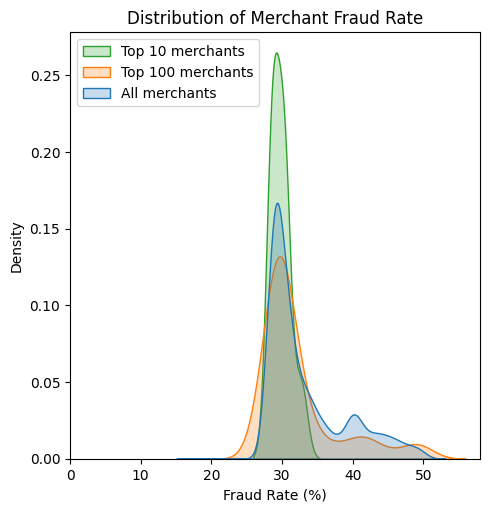

In [543]:
all_merchants = removed_fraud.copy()
all_merchants['subset'] = 'All merchants'

top_100_merchants = removed_fraud.iloc[:100].copy()
top_100_merchants['subset'] = 'Top 100 merchants'

top_10_merchants = removed_fraud.iloc[:10].copy()
top_10_merchants['subset'] = 'Top 10 merchants'

merged_data = pd.concat([all_merchants, top_100_merchants, top_10_merchants])

plt.figure(figsize=(8, 6), frameon=False)
ax = sns.displot(data=merged_data, x='merchant_mean_merchant_fraud_probability', hue="subset", bw_adjust=1, kind="kde", common_norm=False, legend=False, fill=True)
# sns.move_legend(ax, "upper center")

ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)

plt.title("Distribution of Merchant Fraud Rate")
plt.legend(['Top 10 merchants', 'Top 100 merchants', 'All merchants'], loc="upper left")
plt.xlabel("Fraud Rate (%)")
plt.ylabel("Density")
# plt.xlim((0, 7.5))
plt.xlim(0)

plt.show()


<Figure size 800x600 with 0 Axes>

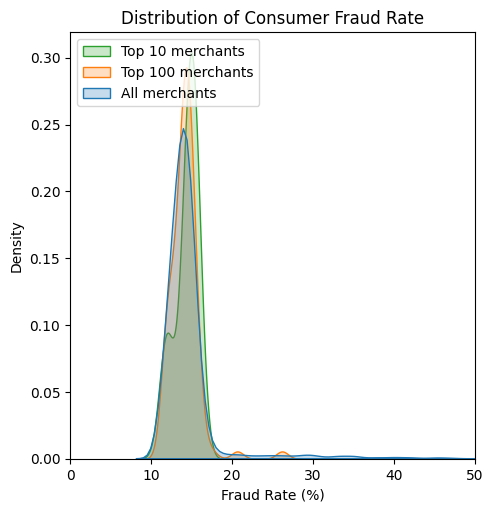

In [545]:
all_merchants = removed_fraud.copy()
all_merchants['subset'] = 'All merchants'

top_100_merchants = removed_fraud.iloc[:100].copy()
top_100_merchants['subset'] = 'Top 100 merchants'

top_10_merchants = removed_fraud.iloc[:10].copy()
top_10_merchants['subset'] = 'Top 10 merchants'

merged_data = pd.concat([all_merchants, top_100_merchants, top_10_merchants])

plt.figure(figsize=(8, 6), frameon=False)
ax = sns.displot(data=merged_data, x='merchant_mean_consumer_fraud_probability', hue="subset", bw_adjust=1, kind="kde", common_norm=False, legend=False, fill=True)
# sns.move_legend(ax, "upper center")

ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)

plt.title("Distribution of Consumer Fraud Rate")
plt.legend(['Top 10 merchants', 'Top 100 merchants', 'All merchants'], loc="upper left")
plt.xlabel("Fraud Rate (%)")
plt.ylabel("Density")
plt.xlim((0, 50))
plt.xlim(0)

plt.show()

In [517]:
removed_fraud

,merchant_abn,merchant_name,merchant_mean_merchant_fraud_probability,merchant_mean_consumer_fraud_probability,dollar_value_skewness,merchant_mean_dollar_value,merchant_mean_expected_revenue,tags,type,take_rate,day_of_month,day_of_year,is_holiday,mean_fraud_probability,mean_household_size,mean_merchant_fraud_probability,median_age,median_family_income,median_household_income,month,moving_average_expected_revenue,moving_average_mean_dollar_value,moving_average_num_sales,postcode_population,total_original_sales,total_seasonal_sales,std_val_score,test_rmse,val_rmse,num_sales_predicted_sum,mean_dollar_value_predicted_sum,expected_revenue_predicted_sum,is_first_100,is_first_10
0,80426072728,Massa Non Ante Industries,33.194406,45.884183,-0.101517,19226.988084,321.637322,"antique, repairs, restoration",a,6.65,-0.016133,0.010191,0.521906,-0.009345,258.86900,-0.130923,30.302800,-0.755530,0.002912,0.121540,0.039329,-0.002756,15.642200,0.003861,-0.000465,-0.000347,672.029045,20.848072,544.444470,0.210062,-3815.394629,-79.026398,1,1
1,18142272571,Ligula Nullam Inc.,30.325838,13.993208,0.485629,2103.059037,39.616976,"motor vehicle supplies, new parts",b,3.25,-0.020442,0.000928,-6.927740,-1.615770,-16.64560,0.646785,-0.272909,0.054919,0.001074,0.000633,0.026617,-0.001071,-0.665961,-0.002941,-0.000191,0.000065,471.275620,157.624089,268.897292,1.820761,-2923.715699,-53.860814,1,1
2,22395185606,Ut Corp.,29.587115,11.153357,0.335790,3060.293231,108.420852,"furniture, home furnishings, equipment, manufa...",a,5.67,0.005286,-0.000258,1.859920,-0.034400,-49.41980,-0.129762,0.042067,0.118121,0.003940,-0.008610,0.924316,-0.027761,-24.200000,-0.000795,-0.000265,0.000119,142.141917,6.478610,115.489581,0.929909,-1313.175057,-40.910261,1,1
3,29681526553,Cras Vehicula Aliquet Corp.,30.292664,13.727374,0.470513,454.314021,17.402496,"tent, awning",a,6.24,-0.028466,0.001581,0.291697,-0.961952,6.03462,0.309246,0.108815,-0.003997,0.001879,0.118339,-0.073646,-0.003856,3.123330,0.000801,-0.000149,-0.000059,94.454556,42.591134,101.501192,3.088978,-169.792079,-9.536066,1,1
4,15527324674,Laoreet Libero LLC,32.744685,11.580948,0.194513,1531.688759,8.427351,"hobby, toy, game",d,0.92,0.002353,0.000148,-1.832830,-0.048069,4.20700,0.032454,-0.026268,0.000325,-0.000257,0.013971,-0.236143,0.000783,0.708188,-0.000080,-0.000022,-0.000005,34.669518,14.329597,86.742830,2.198575,956.654253,2.538440,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3725,32361057556,Orci In Consequat Corporation,30.571478,15.549656,0.189060,109.885529,4.267083,"gift, card, novelty, souvenir",a,6.61,1.059460,0.144380,256.793000,1.668300,-24.05980,0.394052,-1.050590,-0.024774,-0.024091,5.979700,0.101231,-2.656820,1.821850,0.000036,0.000475,0.005718,12.774198,28.590801,36.066237,13503.502480,9854.759773,57547.638641,0,0
3726,38700038932,Etiam Bibendum Industries,30.395338,12.089089,0.192789,1344.342695,52.204740,"tent, awning",a,6.31,0.807221,0.291929,228.114000,-21.074400,20.84850,-4.979140,0.827662,-0.026868,-0.015738,7.249920,0.161972,-0.069358,1.443620,-0.002650,0.006359,0.006536,11.604330,158.514598,168.296277,1138.097079,120922.219727,58785.243713,0,0
3727,86578477987,Leo In Consulting,28.576456,15.140653,0.228560,35.000088,1.364895,"watch, clock, jewelry repair",a,6.43,1.031070,0.106594,241.121000,-5.067250,-6.89176,-0.510031,-1.709580,-0.010705,-0.029435,5.059130,0.240782,-6.113340,0.445062,-0.004941,0.000811,0.007158,23.371538,26.588034,37.514307,43462.394775,3154.342197,59377.411163,0,0
3728,48534649627,Dignissim Maecenas Foundation,28.572027,14.921575,0.304355,141.815857,5.711664,"opticians, optical goods, eyeglasses",a,6.64,1.078470,0.234898,329.638000,-9.028870,-17.18090,-0.797947,-1.605490,-0.022406,0.004249,4.631730,0.287673,-1.235200,1.101680,-0.004594,0.001010,0.009456,14.997147,43.813670,43.891957,10650.902763,12883.300018,61505.107513,0,0


In [470]:
results.pandas_api()['take_rate'].hist()

In [471]:
results.pandas_api()['merchant_mean_merchant_fraud_probability'].hist()

In [472]:
results.pandas_api()['merchant_mean_consumer_fraud_probability'].hist()

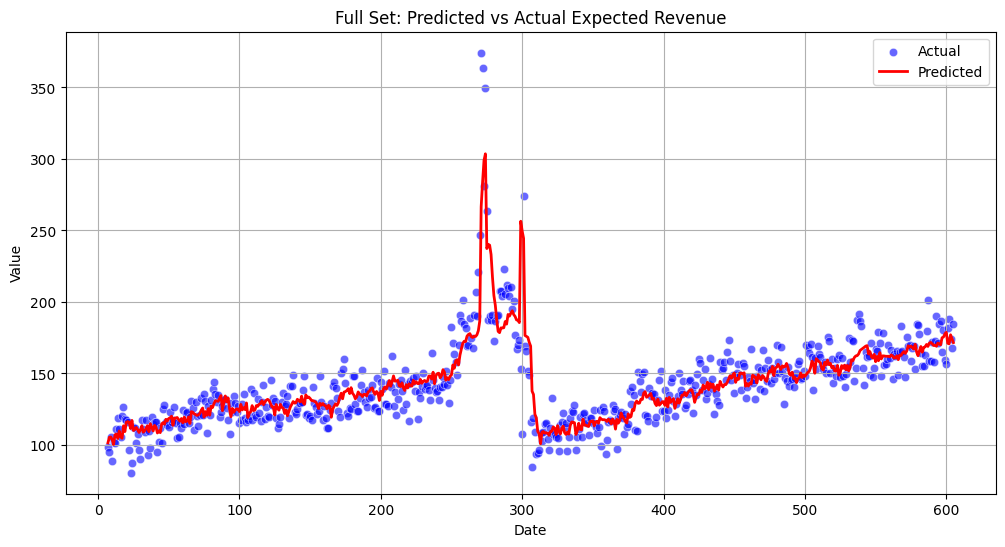

{'estimator__alpha': 0}

In [255]:
plot_predictions(y['expected_revenue'], grid_search.predict(X)[:,0], title='Full Set: Predicted vs Actual Expected Revenue')
grid_search.best_params_

In [441]:
print(df['moving_average_expected_revenue'].max())
print(df['moving_average_expected_revenue'].min())
print(df['moving_average_num_sales'].max())
print(df['moving_average_num_sales'].min())
print(df['median_household_income'].max())
print(df['median_household_income'].min())
print(df['median_family_income'].max())
print(df['median_family_income'].min())
print(df['total_seasonal_sales'].max())
print(df['total_seasonal_sales'].min())

921.5573315015178
301.1599096255395
625.2857142857143
204.85714285714286
1702.9822695035461
1488.8643410852712
2087.68776371308
1836.2596899224807
35150.0
29208.8


In [256]:
grid_search.cv_results_

{'mean_fit_time': array([0.35398784]),
 'std_fit_time': array([0.05290047]),
 'mean_score_time': array([0.0158462]),
 'std_score_time': array([0.00224351]),
 'param_estimator__alpha': masked_array(data=[0],
              mask=[False],
        fill_value=999999),
 'params': [{'estimator__alpha': 0}],
 'split0_test_score': array([-19.79554237]),
 'split1_test_score': array([-18.66089088]),
 'split2_test_score': array([-50.83789786]),
 'split3_test_score': array([-15.0111765]),
 'split4_test_score': array([-12.64587234]),
 'mean_test_score': array([-23.39027599]),
 'std_test_score': array([13.95931701]),
 'rank_test_score': array([1], dtype=int32)}

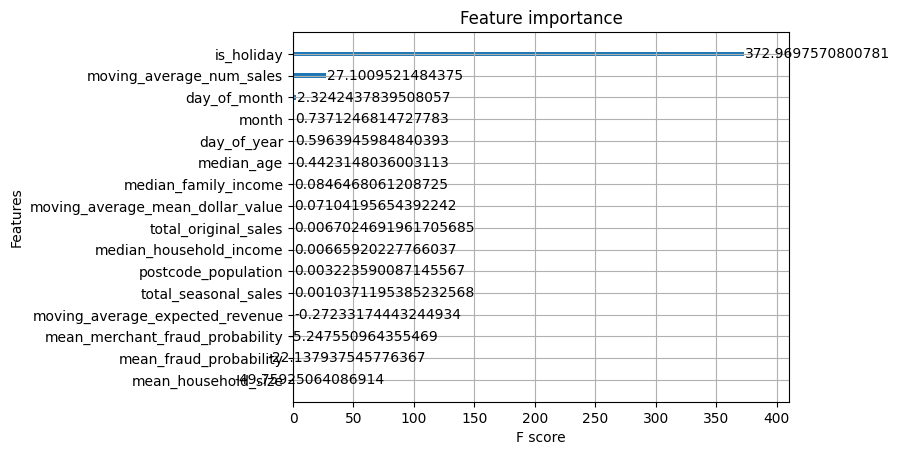

[ 2.32424e+00  5.96395e-01  3.72970e+02 -2.21379e+01 -4.97593e+01
 -5.24755e+00  4.42315e-01  8.46468e-02  6.65920e-03  7.37125e-01
 -2.72332e-01  7.10420e-02  2.71010e+01  3.22359e-03  6.70247e-03
  1.03712e-03]
['day_of_month' 'day_of_year' 'is_holiday' 'mean_fraud_probability'
 'mean_household_size' 'mean_merchant_fraud_probability' 'median_age'
 'median_family_income' 'median_household_income' 'month'
 'moving_average_expected_revenue' 'moving_average_mean_dollar_value'
 'moving_average_num_sales' 'postcode_population' 'total_original_sales'
 'total_seasonal_sales']


In [338]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model.estimators_[0], importance_type='weight')
plt.show()

print(model.estimators_[0].coef_)
print(model.estimators_[0].feature_names_in_)

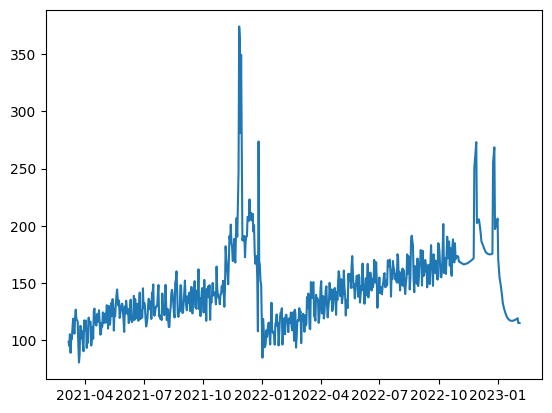

In [212]:
plt.plot(df['order_datetime'], df['expected_revenue'])

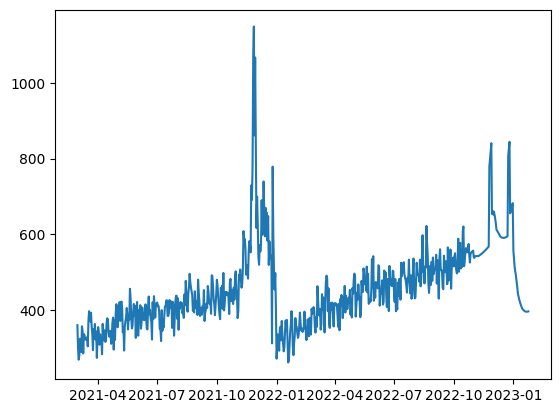

In [372]:
# plt.plot(df['order_datetime'], df['expected_revenue'])
sns.plot()

In [210]:
df.to_csv('test.csv')

In [85]:
transactions = spark.read.parquet("../data/curated/transactions3.parquet")
transactions = transactions.where(F.col("merchant_abn") == '24852446429')
transactions = transactions.groupBy("order_datetime").count().sort(F.col("count").desc())
# transactions = transactions.sort(F.col("order_datetime"), F.col("merchant_abn"))

transactions.show()

+--------------+-----+
|order_datetime|count|
+--------------+-----+
|    2021-11-26| 1053|
|    2021-11-27|  982|
|    2021-11-29|  963|
|    2021-11-28|  796|
|    2021-12-26|  767|
|    2021-11-30|  744|
|    2021-11-25|  718|
|    2021-11-24|  634|
|    2021-12-12|  625|
|    2021-12-15|  596|
|    2021-12-17|  596|
|    2021-11-22|  586|
|    2021-12-10|  583|
|    2021-11-11|  578|
|    2021-12-13|  578|
|    2021-12-14|  576|
|    2021-11-23|  574|
|    2021-12-16|  571|
|    2021-12-02|  567|
|    2021-12-11|  566|
+--------------+-----+
only showing top 20 rows



In [298]:
transactions = spark.read.parquet("../data/curated/transactions3.parquet")
transactions = transactions.groupBy("merchant_abn", "order_datetime").agg(
    F.sum("expected_revenue").alias("expected_revenue"),
    F.mean("fraud_probability").alias("mean_fraud_probability"),
    F.mean("dollar_value").alias("mean_dollar_value"),
    F.count("merchant_abn").alias("num_sales"),
    F.first("tags").alias("tags"),
    F.first("take_rate").alias("take_rate"),
    F.mean("merchant_fraud_probability").alias("mean_merchant_fraud_probability"),
    F.mean("Median_age_persons").alias("median_age"),
    F.mean("Median_tot_fam_inc_weekly").alias("median_family_income"),
    F.mean("Median_tot_hhd_inc_weekly").alias("median_household_income"),
    F.mean("Average_household_size").alias("mean_household_size"),
    F.mean("Tot_P").alias("postcode_population"),
    F.first("day_of_week").alias("day_of_week"),
    F.first("day_of_month").alias("day_of_month"),
    F.first("day_of_year").alias("day_of_year"),
    F.first("month").alias("month"),
    F.first("year").alias("year"),
    F.mean("seasonal_sales").alias("seasonal_sales"),
    F.mean("original_sales").alias("original_sales"),
    F.first("total_seasonal_sales").alias("total_seasonal_sales"),
    F.first("total_original_sales").alias("total_original_sales"),
    F.first("is_holiday").alias("is_holiday"),
)

# transactions.show()
# transactions = transactions.where(F.col("merchant_abn") == '24852446429')
# transactions.pandas_api().plot.scatter("mean_household_size", "expected_revenue")
# transactions.pandas_api().plot.scatter("order_datetime", "mean_household_size")

# transactions.select('order_datetime').sort(F.col('order_datetime').desc()).show()

+--------------+
|order_datetime|
+--------------+
|    2022-10-26|
|    2022-10-26|
|    2022-10-26|
|    2022-10-26|
|    2022-10-26|
|    2022-10-26|
|    2022-10-26|
|    2022-10-26|
|    2022-10-26|
|    2022-10-26|
|    2022-10-26|
|    2022-10-26|
|    2022-10-26|
|    2022-10-26|
|    2022-10-26|
|    2022-10-26|
|    2022-10-26|
|    2022-10-26|
|    2022-10-26|
|    2022-10-26|
+--------------+
only showing top 20 rows



In [188]:
retail_df = spark.read.parquet("../data/raw/retail_sales.parquet")
retail_df = retail_df.withColumn("month", F.month("date"))
retail_df = retail_df.withColumn("year", F.year("date"))
retail_df = retail_df.drop('date')
retail_df = retail_df.select([col for col in retail_df.columns if not col.endswith('trend')])
retail_df.show(truncate=False)
result = retail_df.collect()

retail_sales = {(row['year'], row['month']): row['Total_seasonal'] for row in result}
retail_sales

+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+-----+----+
|NSW_original|VIC_original|QLD_original|SA_original|WA_original|TAS_original|NT_original|ACT_original|Total_original|NSW_seasonal|VIC_seasonal|QLD_seasonal|SA_seasonal|WA_seasonal|TAS_seasonal|NT_seasonal|ACT_seasonal|Total_seasonal|month|year|
+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+-----+----+
|1234.2      |887.0       |494.1       |277.2      |301.5      |77.5        |NULL       |55.3        |3357.8        |1309.8      |952.9       |518.6       |288.9      |321.2      |81.0        |NULL       |58.3        |3561.5        |6    |1982|
|1265.0      |921.3 

{(1982, 6): 3561.5,
 (1982, 7): 3553.9,
 (1982, 8): 3581.8,
 (1982, 9): 3581.2,
 (1982, 10): 3595.6,
 (1982, 11): 3651.7,
 (1982, 12): 3650.4,
 (1983, 1): 3695.6,
 (1983, 2): 3821.0,
 (1983, 3): 3822.8,
 (1983, 4): 3885.2,
 (1983, 5): 3793.2,
 (1983, 6): 3839.4,
 (1983, 7): 3871.1,
 (1983, 8): 3945.5,
 (1983, 9): 3951.4,
 (1983, 10): 3972.3,
 (1983, 11): 3983.3,
 (1983, 12): 4017.6,
 (1984, 1): 4039.3,
 (1984, 2): 4061.2,
 (1984, 3): 4098.9,
 (1984, 4): 4097.7,
 (1984, 5): 4122.3,
 (1984, 6): 4093.2,
 (1984, 7): 4223.6,
 (1984, 8): 4165.1,
 (1984, 9): 4192.8,
 (1984, 10): 4244.7,
 (1984, 11): 4287.0,
 (1984, 12): 4301.7,
 (1985, 1): 4341.1,
 (1985, 2): 4379.3,
 (1985, 3): 4406.6,
 (1985, 4): 4476.7,
 (1985, 5): 4576.7,
 (1985, 6): 4575.1,
 (1985, 7): 4649.3,
 (1985, 8): 4655.3,
 (1985, 9): 4721.8,
 (1985, 10): 4788.2,
 (1985, 11): 4831.2,
 (1985, 12): 4877.1,
 (1986, 1): 4860.9,
 (1986, 2): 4879.8,
 (1986, 3): 4826.5,
 (1986, 4): 4960.5,
 (1986, 5): 5118.0,
 (1986, 6): 5060.9,
 (1986, 